In [326]:
## Main SWR detection analysis! Note there are two ways to analyze the data: a cluster and local version. I keep them
## both updated with changes for now since I tend to check with the local version even if the cluster version is better
## for bulk analysis 2020-6-17 JS
## this version adds in semantic and temporal clsutering analysis. There's an archived version in old_files that ran each
## at the list-level, but now I'm going to focus on temporal clustering at differnt levels (+1 v. ≥3 lags)
## Updated for catFR1 analysis 2020-09-29 JS. Largely edited for manually removing bad electrodes 
## (search for catFR1 in CLUSTER get for example). Carried over changes from SWRanalysis (meant for non-clusering analysis)

In [295]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'catFR1' # 'catFR1' #'FR1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [297]:
# sub lists I've been using for sample code

# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus
# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2
# subs = ['R1112M','R1163T'] #'R1112M' # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1113T']#,'R1137E','R1311T'] # these 3 have eegoffsets of -1 for free recalls so get messed up
# subs = ['R1169P','R1334T','R1368T'] # subs with catFR1 I was testing clustering on
# subs = ['R1486J','R1501J'] # catFR super subjects
# subs = ['R1207J'] # good test sub for clustering
subs = ['R1010J'] # FR1 test

# R1456D, semantic = 1, z-score = -0.84
# R1303E, semantic = 0.64, z-score = -2.1
# R1334T, semantic = 0.78, z-score = 0.55

bad_subs = ['R1433E','R1051J'] # no electrode cats

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[2:4]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events


In [298]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3)) & # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
                    ((df.subject!='R1311T') | (df.session!=0)) & ## these next 3 eegoffset -1 for many recalls so messes things up for clustering analysis ##
                    ((df.subject!='R1113T') | (df.session!=0)) &
                    ((df.subject!='R1137E') | (df.session!=0)) 
                   ] 
if exp == 'catFR1':
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
                    ]
exp_df.shape
# exp_df = exp_df[:255] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[:470] # for FR1 this is R1385E-onwwards
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(475, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
24,NaN,protocols/r1/subjects/R1004D/experiments/catFR...,protocols/r1/subjects/R1004D/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1004D/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1004D/localizations/0/m...,NaN,0,R1004D,R1004D,NaN,protocols/r1/subjects/R1004D/experiments/catFR...
45,NaN,protocols/r1/subjects/R1013E/experiments/catFR...,protocols/r1/subjects/R1013E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1013E/experiments/catFR...,1,NaN,0,protocols/r1/subjects/R1013E/localizations/0/m...,NaN,0,R1013E,R1013E_1,NaN,protocols/r1/subjects/R1013E/experiments/catFR...
58,NaN,protocols/r1/subjects/R1015J/experiments/catFR...,protocols/r1/subjects/R1015J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1015J/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1015J/localizations/0/m...,NaN,0,R1015J,R1015J,NaN,protocols/r1/subjects/R1015J/experiments/catFR...
64,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,0,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
65,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,1,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,1,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359,NaN,protocols/r1/subjects/R1525J/experiments/catFR...,protocols/r1/subjects/R1525J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1525J/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1525J/localizations/0/m...,NaN,3,R1525J,R1525J,3.4,protocols/r1/subjects/R1525J/experiments/catFR...
2360,NaN,protocols/r1/subjects/R1525J/experiments/catFR...,protocols/r1/subjects/R1525J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1525J/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1525J/localizations/0/m...,NaN,4,R1525J,R1525J,3.4,protocols/r1/subjects/R1525J/experiments/catFR...
2361,NaN,protocols/r1/subjects/R1525J/experiments/catFR...,protocols/r1/subjects/R1525J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1525J/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1525J/localizations/0/m...,NaN,5,R1525J,R1525J,3.4,protocols/r1/subjects/R1525J/experiments/catFR...
2362,NaN,protocols/r1/subjects/R1525J/experiments/catFR...,protocols/r1/subjects/R1525J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1525J/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1525J/localizations/0/m...,NaN,6,R1525J,R1525J,3.4,protocols/r1/subjects/R1525J/experiments/catFR...


## CLUSTER get SWRs after removing IEDs!

In [227]:
def ClusterRunSWRs(param):

    import pandas as pd
    import numpy as np
    import os
    import sys; sys.path.append('/home1/john/johnModules')
    import dill, pickle
    import mne
    from scipy.signal import firwin,filtfilt,kaiserord
    from ptsa.data.filters import ButterworthFilter
    from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
    %load_ext autoreload
    %autoreload
    from SWRmodule import CMLReadDFRow,get_bp_tal_struct,get_elec_regions,ptsa_to_mne
    from SWRmodule import detectRipplesHamming
    from general import superVstack
    from SWRmodule import downsampleBinary,LogDFExceptionLine,getBadChannels,getStartEndArrays,getSecondRecalls,\
                        removeRepeatedRecalls,getSWRpathInfo,selectRecallType,getMTLregions,correctEEGoffset,\
                        removeRepeatsBySerialpos,findAinB,get_recall_clustering,getSerialposOfRecalls,getRetrievalStartAlignmentCorrection
    import pingouin as pg
    HPC_labels,ENT_labels,PHC_labels = getMTLregions(MTL_labels)
    
    ### PARAMS ###
    
    ##
    ## NOTE: for looking at individual lags make sure min_recalls is set to 0 or will eliminate trials from low recall lists
    ##
    
    save_values = 1
    
    selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
    # there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period
    recall_type_switch = 4  # switch to determine which recalls to look at! (see details below)
    # 0: Original analysis taking only recalls without a recall in 2 s IRI before them
    # 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur 
    # 2: test condition where we look at second recalls within IRI ONLY (there is an initial recall in 2 s before current recall)
    # 3: isolated recalls with no other recalls +/- RECALL_MINIMUM s
    # 4: only first recall of every retrieval period
    # 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
    # 6: take only NOT first recall of every retrieval period
    # 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
    # 10: same as 0 but with no IRI (mostly just to see number of recalls)

    selected_region = HPC_labels   #HPC_labels #HPC_labels # ENT_labels 

    remove_soz_ictal = False # False only removes bad electrodes and not soz/ictal
    min_ripple_rate = 0.1 # Hz.
    max_ripple_rate = 1.5 # Hz.
    max_trial_by_trial_correlation = 0.05 # if ripples correlated more than this remove them
    max_electrode_by_electrode_correlation = 0.2 #???

    ### semantic/temporal clustering parameters ###
    min_recalls = 0
    PCA_ndim = 1 # number of PC dims to use for semantic clustering (Ethan usually found only 1 worked for theta/FC)
    
#     # for parametric run through recall_minimums
#         recall_mins = np.arange(800,5100,100) #[800,900,1100,1200,1300,1400]
# #     recall_mins = [1600,1700,1800,1900,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]
#     for recall_minimum in recall_mins:
    
    # recall params
    recall_minimum = 2000 # for isolated recalls what is minimum time for recall to be considered isolated?
    IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
    retrieval_whole_time = 10000
    # encoding params
    encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
    pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
    # these aren't likely to be changed:
    desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
    filter_type = 'hamming' # see local version below for details. 'butter' is removed from cluster version so don't change this
    eeg_buffer = 300 # buffer to add to either end of IRI when processing eeg #**
    
    ### END PARAMS ###

    if 'entorhinal' in selected_region and 'left hippocampus' in selected_region:
        region_name = 'HPC_ENT' # these just get names for file save at bottom
    elif 'entorhinal' in selected_region:
        region_name = 'ENT'
    elif 'left hippocampus' in selected_region:
        region_name = 'HPC'
    elif 'parahippocampal' in selected_region:
        region_name = 'PHC'
    if selected_period == 'surrounding_recall':
        psth_start = -IRI # only makes sense to look at period <= IRI
        psth_end = IRI # how long to grab data after recall
    elif selected_period == 'whole_retrieval':
        psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
        psth_end = IRI+retrieval_whole_time
    elif selected_period == 'encoding':
        psth_start = pre_encoding_time
        psth_end = encoding_time

    ripple_array = []; fr_array = []; 
    trial_nums = []; 
    HPC_names = []; sub_sess_names = []; sub_names = []
    electrodes_per_session = []
    total_lists = 0; total_recalls = 0; kept_recalls = 0
    align_adjust = 0
    ent_elec_ct = []; sd_regions = []; not_sd_regions = []
    ripple_ied_accum_ct = []
    time_add_save = []
    encoded_word_key_array = []; serialpos_array = [] # encoding info
    
    trial_by_trial_correlation = []; elec_by_elec_correlation = []
    session_ripple_rate_by_elec = []; elec_ripple_rate_array = []

    semantic_clustering_key = []
    temporal_clustering_key = []
    serialpos_lags = []
    list_trial_nums = []; list_num_key = []
    list_level_semantic = []; list_level_temporal = []
    
    channel_coords = []; electrode_labels = []
    
    program_ran = 0
    try:
        with open('temp_dfSWR.p', 'rb') as f: ### change here to avoid overwrite
            temp_df = dill.load(f)   
        row = temp_df[param]
        sub = row.subject; session = row.session; exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        evs = reader.load('task_events')
        evs_free_recall = evs[(evs.type=='REC_WORD')] #& (evs.recalled==True)] # recalled word AND correct (from this list...no instrusions). 
                        # deal with intrusions after checking clustering to ensure removing them doesn't create fake transitions

        # need to remove free recalls that happened more than once
        word_evs = evs[evs['type']=='WORD'] # get words 
        
        session_words = word_evs.item_name.unique()
        if len(findAinB(['BARRO','CABALLO','COSTILLA','DULCE','FICHA','ESTUFA','GALLINA','FRIJOL',
                        'GUARDIA','HILO','JEFE','LABIO','MAIZ','NIEVE','ORO','PALMA','PECHO','PLATO',
                        'RANA','SAPO','SERPIENTE','TALLO','UVA','VIGA','ZAPATO'],session_words))>0:
            sys.exit() # skip Spanish sessions
        else:
            from sklearn.decomposition import PCA
            semantic_model = pickle.load(open('/home1/john/SWR/code/semantic_analysis/'+exp+'_wordpool_feats.pk', 'rb')) # dictionary of all exp words
            
            # get good lists to run through
            list_nums = evs_free_recall.list.unique()[evs_free_recall.list.unique()>0] # make sure not a practice list
            no_eeg_lists = evs_free_recall[evs_free_recall.eegoffset == -1].list.unique() # if any recalls in list don't have eeg remove that list
            list_nums = [i for i in list_nums if i not in no_eeg_lists] 
            
            list_mask = []
            temp_semantic_key = []
            temp_temporal_key = []
            temp_serialpos_lags = []
            temp_list_trial_nums = []; temp_list_num_key = []
            temp_list_level_semantic = []; temp_list_level_temporal = []
            
            for ln in list_nums:
                
                recalls_serial_pos = getSerialposOfRecalls(evs_free_recall,word_evs,ln) # note that intrusions become -999

                # get differences in lags before removing repeats
                list_serialpos_lags = np.append(np.diff(recalls_serial_pos),0) # absolute differences in lags with a 0 at end for last output
            
                # leave intrusions and repeats in for now so can assess clustering with them included
                # ...but still want to know how many legit recalls there are for min_recalls threshold
                temp_serialpos,_ = removeRepeatsBySerialpos(recalls_serial_pos) # remove repeats
                num_true_recalls = len(temp_serialpos[temp_serialpos!=-999])# how many non-intrusions (note that all but 1 -999s removed in last line)
                 
                if num_true_recalls >= min_recalls:
                    list_mask.append(ln) # update kept list mask
                    
                    # now get semantic and temporal values for this list
                    
                    serial_pos = np.array(recalls_serial_pos)-1 # zero index the serialpos
#                     serial_pos = [int(list_words_df[list_words_df['item_name']==w]['serialpos'])-1 for w in list_recalls_df['item_name']] # serialpos starting at 0
                    list_recalls_df = evs_free_recall[evs_free_recall.list==ln] # recalls df just for this list
                    list_words_df = word_evs[word_evs.list==ln] # words df just for this list
        
                    words = list(list_words_df['item_name']) 
                    if 'AXE' in words: # GoogleVec doesn't have this spelling of ax (fix for semantic clustering)
                        list_words_df = list_words_df.replace('AXE','AX')
                        list_recalls_df = list_recalls_df.replace('AXE','AX')
                    
                    # semantic clustering
        
                    if exp == 'FR1':
                        # Decided not to use semantic for FR1 for now but if you do I think FR1_wordpool_feats.pk needs to be recompiled via SWRgetWordList.ipynb 2020-10-19
                        # also should make sure semantic_transition_scores look kosher since made some changes to get_recall_clustering to fix temporal clustering of intrusions
                
                        #Project semantic features for this list to 1 dimension
                        feats = np.array([semantic_model[w] 
                                          for w in list_words_df['item_name']
                                         ])  #construct feature matrix from this list; # WORDs X 300 vecs
                        pca = PCA(n_components=PCA_ndim)
                        pcs = pca.fit_transform(feats) # list of ndim PCs for 12 words

                        # Get semantic cluster transition pairwise values 
                        semantic_transition_scores = np.array(get_recall_clustering(pcs, serial_pos))
                        semantic_list_mean = np.nanmean(semantic_transition_scores[semantic_transition_scores > -990])
                        temp_semantic_key.extend(semantic_list_mean*np.ones(len(list_recalls_df))) # extend by # of recalls for key
                        if len(list_recalls_df)>0:
                            temp_semantic_key[-1] = 'nan' # last recall in every list didn't lead to a transition. So don't give a value
                    elif exp == 'catFR1':
                        # have to use special structure of catFR1 to divide into near v. remote semantic transitions
                        # there's also adjacent v. non-adjacent. so create 2x2 recalls as well as dead ends (no transition from last one)
                        
                        # category numbers to identify semantic transitions
                        item_names = list_recalls_df['item_name']
                        category_nums = [] # don't use list comprehensions so can put -999s in for intrusions
                        for w in item_names:
                            if w in np.array(list_words_df['item_name']):
                                category_nums.append(int(list_words_df[list_words_df['item_name']==w]['category_num']))
                            else:
                                category_nums.append(-999)

                        for recall in np.arange(len(serial_pos)):
                            # it's ok if intrusions or repeats are in here since will be removed later
                            if recall == len(serial_pos)-1: # if last one, no transition happens after this, so put a dummy letter
                                temp_semantic_key.extend('Z')
                            else:
                                transition_dist = np.abs(serial_pos[recall+1]-serial_pos[recall])
                                if transition_dist == 1:
                                    # use single letters and not words since I used extend for FR1 semantic values
                                    if category_nums[recall+1] == category_nums[recall]:
                                        temp_semantic_key.extend('A') # leads to adjacent semantic
                                    else:
                                        temp_semantic_key.extend('B') # leads to adjacent other
                                elif category_nums[recall+1] == -999:
                                    temp_semantic_key.extend('I') # this one leads to an intrusion next
                                elif item_names.iloc[recall] == item_names.iloc[recall+1]:
                                    temp_semantic_key.extend('R') # consecutive repeats
                                else: 
                                    if category_nums[recall+1] == category_nums[recall]:
                                        temp_semantic_key.extend('C') # leads to remote semantic
                                    else:
                                        temp_semantic_key.extend('D') # leads to remote other 
                                        
                    # do temporal clustering
                    
                    temporal_transition_scores = np.array(get_recall_clustering(np.arange(len(list_words_df)), serial_pos))
                    # average those values that aren't intrusions/repeats 
                    temporal_list_mean = np.nanmean(temporal_transition_scores[temporal_transition_scores > -990])
                    temp_temporal_key.extend(temporal_list_mean*np.ones(len(list_recalls_df)))
                    if len(list_recalls_df)>0:
                        temp_temporal_key[-1] = 'nan' # last recall in every list didn't lead to a transition. So don't give a value

                    # keep track of lags
                    temp_serialpos_lags.extend(list_serialpos_lags)  
                    
                    # keep track of number of trials in each so can select by minimum later on
                    temp_list_trial_nums.append(len(list_recalls_df))
                    temp_list_num_key.append(ln)
                    
                    # for whole_retrieval analysis need list-level scores for temporal/semantic clustering
                    temp_list_level_temporal.append(temporal_list_mean) # single value for each list
                    if exp == 'FR1':
                        temp_list_level_semantic.append(semantic_list_mean) # they're list_level values for FR1 so just grab first of list
                    else: # for catFR keep list of lists since will have to go through later to assess minimum As or Cs or whatever
                        temp_list_level_semantic.append(temp_semantic_key[-len(serial_pos):]) # grab all of them for this list since will weigh A v B v C v D later
            
        evs_free_recall = evs_free_recall[evs_free_recall.list.isin(list_mask)] # get recalls from qualifying lists
        # need to remove free recalls that happened more than once (list_mask doesn't account for these)        
#         evs_free_recall = removeRepeatedRecalls(evs_free_recall,word_evs)
#         evs_free_recall = evs_free_recall[evs_free_recall.eegoffset > -1]
      
        # select which recalls??         
        [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)
        
        # now have recalls you want after including intrusions and repeats for clustering & IRI purposes
        # ...so remove them and update selected_recall_idxs (since this is key to select clustering values down below)
        _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs)
        nonintrusion_idxs = np.array(evs_free_recall.intrusion==0)
        selected_recalls_idxs = selected_recalls_idxs & (nonrepeat_indicator>0) & nonintrusion_idxs

        evs_free_recall = evs_free_recall[selected_recalls_idxs]

        if len(evs_free_recall)==0:
            sys.exit()
        
        # get localizations (region info)
        pairs = reader.load('pairs')
        try:
            localizations = reader.load('localization')
        except:
            localizations = []
        tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
        elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs) 
        
        ###  load eeg ###
        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall
        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
#             evs_rets = evs_rets[evs_rets.eegoffset>-1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 
#             evs_rets = evs_rets[evs_rets.list>-1] # remove practice lists
            # in clustering I make a list_mask, so use that to select which trials to get EEG for
            evs_rets = evs_rets[evs_rets.list.isin(list_mask)]
            eeg_events = evs_rets
            
            # get alignmnet of end of beep time to EEG so can align retrieval to end of beep across all sessions
            align_adjust = getRetrievalStartAlignmentCorrection(sub,session,exp) # in ms
            
        elif selected_period == 'encoding':
            # I'm going to save encoding word events too, but need a mask to keep track of:
            # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
            evs_encoding_words = evs[evs.type=='WORD']
            evs_encoding_words = evs_encoding_words[evs_encoding_words.eegoffset>-1]
            encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
            encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
            encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
            # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
            eeg_events = evs_encoding_words
            
        # fixing bad trials
        if sub == 'R1045E' and exp == 'FR1': # this one session has issues in eeg trials past these points so remove events
            
            sys.exit() # too difficult to deal with for clustering analysis   
            
            if selected_period == 'surrounding_recall':
                eeg_events = eeg_events.iloc[:65,:] # only the first 66 recalls have good eeg
            elif selected_period == 'whole_retrieval':
                eeg_events = eeg_events.iloc[:20,:] # only the first 20 retrieval periods have good eeg
            elif selected_period == 'encoding':
                eeg_events = eeg_events.iloc[:263,:] # same idea
                encoded_word_key = encoded_word_key[:263]
                
        # fix EEG offset due to Unity implementation error
        eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)

        # note I added the align_adjust now for whole_retrieval where I adjust all retrieval starts to beep_end
        eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                              rel_stop=psth_end+eeg_buffer+align_adjust, clean=True, scheme=pairs) 
        # events X electrodes X time
        sr = eeg.samplerate

        # if weird samplerate, add a few ms to make the load work
        if (499<sr<500) | (998<sr<1000):
            time_add = 1
            if (499<sr<500):
                sr = 500
            elif (998<sr<1000):
                sr = 1000
            while eeg.shape[2] < (psth_end-psth_start+2*eeg_buffer)/(1000/sr):
                eeg = reader.load_eeg(events=eeg_events, rel_start=int(psth_start-eeg_buffer+align_adjust), 
                                      rel_stop=int(psth_end+eeg_buffer+time_add+align_adjust), clean=True, scheme=pairs)
                if time_add>50: #** 
                    sys.exit()
                time_add+=1
            time_add_save.append(time_add)
            eeg.samplerate = sr # need to overwrite those that were just fixed

        eeg_ptsa = eeg.to_ptsa()
        eeg = None # clear variable
        
        # line removal...don't do 120 for now
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()

        ## FILTERS ##
        trans_width = 5.
        ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sr/trans_width) # gives 400 with sr=500, trans=5
        if sr == 512 or sr == 1024 or sr == 1023.999: # last one fixes R1221P
            ntaps = np.ceil(ntaps)
        FIR_bandstop = firwin(int(ntaps+1), [70.,178.], fs=sr, window='hamming',pass_zero='bandstop')
    #     FIR_bandpass = firwin(int(ntaps), [70.,180.], fs=sr, window='hamming',pass_zero='bandpass')
        bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED
    #     bandstop_60_80 = firwin(int(ntaps+1), [60.,80.], fs=sr, window='hamming',pass_zero='bandstop') # Gelinas 2016 IED
        nyquist = sr/2
        ntaps40, beta40 = kaiserord(40, trans_width/nyquist)
        kaiser_40lp_filter = firwin(ntaps40, cutoff=40, window=('kaiser', beta40), scale=False, nyq=nyquist, pass_zero='lowpass')

        # filter for ripples using filter selected above
        if filter_type == 'hamming':
            # need to subtract out to get the filtered signal since default is bandstop but want to keep it as PTSA        
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop,1.,eeg_ptsa) 
            #         eeg_rip_band = filtfilt(FIR_bandpass,1.,eeg_ptsa) # can't use ptsa_to_mne this way so use eeg-bandstopped signal
            eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa)   
        eeg_ptsa = None # clear variable

        eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
        _ = eeg_rip_band.apply_hilbert(envelope=True)
        eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
        _ = eeg_ied_band.apply_hilbert(envelope=True)
        
        # get bad channel mask
        try:
            elec_cats = reader.load('electrode_categories') # this is cool
        except:
            if remove_soz_ictal == True:
                sys.exit() # don't know soz/ictal sites so skip this session
            else:
                elec_cats = [] # not removing these sites anyway so keep on keeping on
#             e = 'No electrode categories for '+sub+', session '+str(session)
#             LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
        
        bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)
        
        # remove bad range of electrodes (high noise)
        electrode_search_range = range(len(elec_regions))
        if exp == 'FR1':
            if sub == 'R1120E':
                electrode_search_range = range(30) # HPC elecs after 25:26 have lots of artifacts that get picked up as SWRs. See subject figure PPT
            elif sub == 'R1349T': # channels 90 and below have tons of artifcats. After that looks okay though
                electrode_search_range = range(91,len(elec_regions))
            elif sub == 'R1397D': # for these two sessions two pairs of the electrodes have lots of correlated noise. Remove them
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 60]
                electrode_search_range.remove(110)
            elif sub == 'R1332M' and session == 1:
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 48] # some real weird bands in these couple sessions
                electrode_search_range.remove(49)
            elif sub == 'R1299T':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 34] # see PPT. These two pairs shared an electrode and had tons of correlated artifacts
                electrode_search_range.remove(43) 
        # note that I'm okay with overlap in say entorhinal also removing hippocampal channels. So don't specify region in these
        # just assume that the overlap exists in all cases
        elif exp == 'catFR1':
            if sub == 'R1269E':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 11] # 10, 11, 54, 55 all look identical in HPC raster so remove latter 3
                electrode_search_range.remove(54) # (see SWR catFR1 problem sessions ppt for details)
                electrode_search_range.remove(55)
            elif sub == 'R1328E':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 38] # overlapping signal with ch 37
            elif sub == 'R1367D':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 71] # overlapping signals with neighbor
                electrode_search_range.remove(96)
            elif sub == 'R1397D':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 110]
                electrode_search_range.remove(60) 
            elif sub == 'R1405E' and mont==0:
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 44]
            elif sub == 'R1405E' and mont==1:
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 79]
            elif sub == 'R1447M': # overlapping with neighbors. again documented in SWR catFR1 problem sessions ppt 
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 15]
                electrode_search_range.remove(17)
            elif sub == 'R1469D':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 16]
            elif sub == 'R1489E':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 3] # first entorhinal...see catFR1 prob session ppt
                electrode_search_range.remove(55)
            elif sub == 'R1400N':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 39] # entorhinal...middle of 3 consecutive channels
            elif sub == 'R1190P':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 96] # entorhinal...3rd of 4 consecutive channels
            elif sub == 'R1092J':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 39] # entorhinal...3rd of 4 consecutive channels
            elif sub == 'R1028M':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 8] # entorhinal...3rd of 4 consecutive channels
            elif sub == 'R1107J':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 3] # parahippocampal...4th of 5 consecutive channels
            elif sub == 'R1364C':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 60] # parahippocampal...3rd of 4 consecutive channels
                
        # go through each channel in given region and detect ripples!
                        
        region_electrode_ct = 0
        for channel in electrode_search_range:
            if (elec_regions[channel] in selected_region) & \
            (bad_bp_mask[channel] == 0): # don't use bad electrodes

                # get data from MNE container
                eeg_rip = eeg_rip_band.get_data()[:,channel,:]     
                eeg_ied = eeg_ied_band.get_data()[:,channel,:]

                # select detection algorithm (note that iedlogic is same for both so always run that)

                if filter_type == 'hamming':
                    # filter IEDs 
                    eeg_ied = eeg_ied**2 # already rectified now square
                    eeg_ied = filtfilt(kaiser_40lp_filter,1.,eeg_ied) # low pass filter  
                    mean1 = np.mean(eeg_ied)
                    std1 = np.std(eeg_ied)
                    iedlogic = eeg_ied>=mean1+4*std1 # Norman et al 2018             
                    # detect ripples
                    ripplelogic = detectRipplesHamming(eeg_rip,trans_width,sr,iedlogic)             

                if sr>desired_sample_rate: # downsampling here for anything greater than 500
                    ripplelogic = downsampleBinary(ripplelogic,sr/desired_sample_rate)
                    
                # ripples are detected, so can remove buffers now #**
                ripplelogic = ripplelogic[:,int(eeg_buffer/(1000/desired_sample_rate)):
                                          int((psth_end-psth_start+eeg_buffer)/(1000/desired_sample_rate))]  
    
                # skip this electrode if the ripple rate is below threshold
                temp_start_array,_ = getStartEndArrays(ripplelogic)
                elec_ripple_rate = np.sum(temp_start_array)/temp_start_array.shape[0]/((psth_end-psth_start)/1000)
                if elec_ripple_rate < min_ripple_rate:
#                     print(sub+', '+str(session)+' skipped b/c below ripple rate thresh for ch.: '+str(channel))
                    continue
                elif elec_ripple_rate > max_ripple_rate:
#                     print(sub+', '+str(session)+' skipped b/c ABOVE ripple rate thresh for ch.: '+str(channel))
                    continue # skip this electrode

                # check the ripples for this electrode and make sure they're not super correlated across trials

                # first, bin the array so can get more realistic correlation not dependent on ms timing
                binned_ripplelogic = downsampleBinary(ripplelogic,10) # downsample by 10x so 10 ms bins
                trial_ripple_df = pd.DataFrame(data=np.transpose(binned_ripplelogic))
                num_cols = len(list(trial_ripple_df))
                trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
                temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)
                if temp_tbt_corr > max_trial_by_trial_correlation:
#                     print(sub+', '+str(session)+' skipped b/c above trial-by-trial correlation for ch.: '+str(channel))
                    continue
    
                ## if this electrode passes SAVE data ##
                
                if selected_period == 'surrounding_recall': 
                    if len(np.array(temp_semantic_key)[selected_recalls_idxs]) != len(ripplelogic):
                        # eegoffsets with -1 should be removed above anyway but keep as a check
                        sys.exit()
        
                trial_by_trial_correlation.append(temp_tbt_corr) # corr b/w trials
                elec_ripple_rate_array.append(elec_ripple_rate) # record the average ripple rate for this electrode 

                # append arrays across electrodes
                ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
                session_ripple_rate_by_elec = superVstack(session_ripple_rate_by_elec,np.mean(binned_ripplelogic,0)) # for correlation b/w elecs below
                
                # get other info
                if selected_period == 'encoding':
                    encoded_word_key_array.append(encoded_word_key) # save the key for each electrode so easier to unpack later
                    serialpos_array.append(evs_encoding_words.serialpos)
                    if len(encoded_word_key) != ripplelogic.shape[0]:
                        e = 'Encoded word key and ripple_array dont match for '+sub+str(session)+'_'+str(channel)
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                        
                if selected_period == 'whole_retrieval':
                    # make a matrix of the times of free recall if looking at whole retrieval period
                    list_nums = evs_rets.list.unique() # count all list numbers for this session
                    temp_fr_array = np.zeros((len(list_nums),retrieval_whole_time),dtype=np.int8)
                    for ln in list_nums:
                        list_times = np.array(evs_free_recall[evs_free_recall.list==ln].mstime) - \
                                    (np.array(evs_rets[evs_rets.list==ln].mstime) + align_adjust) # align all times to end of beep
#                         list_times = evs_free_recall[evs_free_recall.list==ln].rectime # I confirmed these are accurate relative to REC_START
                        for i,list_time in enumerate(list_times):
                            if list_time <= retrieval_whole_time:
                                # used to do ln-1 instead of i to get order opposite but doesn't work now since I remove lists
                                temp_fr_array[i][int(np.round(list_time))] = 1 
                    fr_array = superVstack(fr_array,temp_fr_array)
                
                semantic_clustering_key.extend(np.array(temp_semantic_key)[selected_recalls_idxs])
                temporal_clustering_key.extend(np.array(temp_temporal_key)[selected_recalls_idxs])
                serialpos_lags.extend(np.array(temp_serialpos_lags)[selected_recalls_idxs])

                # record list-level numbers (for whole_retrieval analysis)
                list_trial_nums.extend(temp_list_trial_nums) 
                list_num_key.extend(temp_list_num_key)
                list_level_temporal.extend(temp_list_level_temporal)
                list_level_semantic.extend(temp_list_level_semantic)
                
                trial_nums = np.append(trial_nums,ripplelogic.shape[0])
                region_electrode_ct+=1 # channel ct for this session
                HPC_names.append(elec_regions[channel])
                sub_sess_names.append(sub+'-'+str(session))
                sub_names.append(sub)
                electrode_labels.append(pairs.iloc[channel].label) # get names of electrodes so can look for them across sessions
                
                # get atlas coordinates for this electrode
                if 'avg.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['avg.x'],np.append(pairs.iloc[channel]['avg.y'],pairs.iloc[channel]['avg.z']))
                elif 'ind.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['ind.x'],np.append(pairs.iloc[channel]['ind.y'],pairs.iloc[channel]['ind.z']))
                else:
                    temp_coord = np.empty(3); temp_coord[:] = np.nan
                channel_coords.append(temp_coord)
                
        program_ran = 1          
        # before we keep all the electrodes in this session, remove electrodes that are highly correlated.
        # this really only makes sense for the cluster version, since I only do a session at a time here
        if np.sum(session_ripple_rate_by_elec)>0 and region_electrode_ct>1:
            session_ripple_df = pd.DataFrame(data=np.transpose(session_ripple_rate_by_elec))
            num_cols = len(list(session_ripple_df))
            session_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
            elec_by_elec_correlation = np.mean(pg.pairwise_corr(session_ripple_df,method='spearman').r) # correlation b/w elecs 
            if elec_by_elec_correlation > max_electrode_by_electrode_correlation:
#                 e = sub+', '+str(session)+' had correlation over '+str(max_electrode_by_electrode_correlation)+\
#                     ' b/w electrodes so skipped; corr = '+str(elec_by_elec_correlation)
#                 LogDFExceptionLine(row, e, 'ClusterRunSWR_log.txt')
                program_ran = 0

    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterRunSWR_log.txt') #np.save('SWRscript_FR1.npy', ['Exception', str(e.__class__), str(e)])
        #continue

    if save_values == 1 and program_ran == 1:
        # get strings for path name for save and loading cluster data
        soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
        path_name = '/scratch/john/SWR_semantic_scratch/'+subfolder
        if os.path.isdir(path_name) == False:
            os.mkdir(path_name)
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+'_'+soz_label+'_recalls-'+str(min_recalls)+'.p')           
        with open(fn,'wb') as f:
            pickle.dump({'region_electrode_ct':region_electrode_ct, 
                        'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                        'ripple_array':ripple_array, 'time_add_save':time_add_save,
                        'trial_nums':trial_nums, 
                        'encoded_word_key_array':encoded_word_key_array,'serialpos_array':serialpos_array,
                        'fr_array':fr_array, 'sub_names':sub_names,
                        'total_recalls':total_recalls, 'kept_recalls':kept_recalls,
                        'trial_by_trial_correlation':trial_by_trial_correlation, # one value for each electrode for this session
                        'elec_by_elec_correlation':elec_by_elec_correlation,
                        'elec_ripple_rate_array':elec_ripple_rate_array,
                        'semantic_clustering_key':semantic_clustering_key,'temporal_clustering_key':temporal_clustering_key,
                        'serialpos_lags':serialpos_lags, 
                        'list_trial_nums':list_trial_nums,'list_num_key':list_num_key,
                        'list_level_semantic':list_level_semantic, 'list_level_temporal':list_level_temporal,
                        'electrode_labels':electrode_labels,'channel_coords':channel_coords}, f)

os.chdir('/home1/john/SWR/cluster') # where temp files will go

# save as dill so can bypass pickling in ipython for cluster parallelization
import dill
temp_df = list(exp_df.itertuples()) # exp_df is whole enchilada! sub_df to test things
with open('temp_dfSWR.p', 'wb') as f: 
    dill.dump(temp_df,f)
params = []
for i in range(len(temp_df)):
    params.append(i)

ClusterRun(ClusterRunSWRs, params)

print('finished ClusterRunSWRs!!')

100 Engines running
Sending a shutdown signal to the controller and engines.


CompositeError: one or more exceptions from call to method: ClusterRunSWRs
[2:apply]: SystemExit: 
[45:apply]: SystemExit: 
[68:apply]: SystemExit: 
[26:apply]: SystemExit: 
.... 10 more exceptions ...

In [48]:
fileDeleter("/home1/john/SWR/cluster/","sge_engine")
fileDeleter("/home1/john/SWR/cluster/","sge_controller")
fileDeleter("/home1/john/SWR/cluster/","bcbio-")

## Load CLUSTER data

In [301]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used
selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
recall_type_switch = 6  #  0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
    # 4: only first recall of every retrieval period
    # 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
    # 6: take only NOT first recall of every retrieval period
    # 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
    # 10: same as 0 but with no IRI (mostly just to see number of recalls)
# (1 and 3 are basically opposites...those with a subsequent recall and those without)
recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC
remove_soz_ictal = False

min_recalls = 0 # keep lists with ≥ this many recalls

###
# wait why is this still here only for SWR clustering??

# # for loading still use original exp_df since that's what I used to split into half subjects
# load_exp_df = df[df.experiment==exp]
# load_exp_df = load_exp_df[
#                 ((df.subject!='R1015J') | (df.session!=0)) & 
#                 ((df.subject!='R1063C') | (df.session!=1)) & 
#                 ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
#                 ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
#                 ((df.subject!='R1120E') | (df.session!=0)) &
#                 ((df.subject!='R1122E') | (df.session!=2)) &
#                 ((df.subject!='R1154D') | (df.session!=0)) &
#                 ((df.subject!='R1186P') | (df.session!=0)) &
#                 ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
#                 ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
#                 ((df.subject!='R1277J') | (df.session!=0)) &
#                 ((df.subject!='R1413D') | (df.session!=0)) & 
#                 ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
#                 ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
#                 ((df.subject!='R1275D') | (df.session!=3)) # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
#                ] 
# load_exp_df.shape

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

ripple_array = []; 
trial_nums = []; encoded_word_key_array = []; serialpos_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []

electrode_labels = []; channel_coords = []

semantic_clustering_key = []
temporal_clustering_key = []
serialpos_lags = []
list_trial_nums = []; list_num_key = []
list_level_temporal = []; list_level_semantic = []

# Makes most sense to take half the subjects 
if exp == 'FR1':
    np.random.seed(44462) # seed 44462 gives 25,845 of 60,417 recall trials (42.8%). Or 57/167 (34.1% of subs)
    from SWRmodule import total_sub_names_FR1 # all the unique sub names for FR1 task in df
    total_sub_names = copy(total_sub_names_FR1)
    proportion_subs = 0.5 # it's really 0.5 of initial pre-localization.pairs subs. So comes out to numbers above. And what we want to match for catFR1
elif exp == 'catFR1':
    np.random.seed(44455) # seed 44455 gives 20,393 of 50,053 recall trials (40.7%). Or 47/136 (34.6% of subs)
    from SWRmodule import total_sub_names_catFR1 # all the unique sub names for FR1 task in df
    total_sub_names = copy(total_sub_names_catFR1)
    proportion_subs = 0.35 # 0.5
random_half_sub_names = np.random.permutation(np.unique(total_sub_names))[:int(np.floor(len(np.unique(total_sub_names))*proportion_subs))]
random_half_sub_names[:10] # just to see them
random_half_sub_names[-10:]
half_sub_idxs = np.array(findAinB(random_half_sub_names,exp_df.subject))
half_df = exp_df.iloc[half_sub_idxs]


## run through subjects

for row in half_df.itertuples(): #sub_df.itertuples():  #half_df.itertuples(): ### DON'T CHANGE THIS TO EXP
    try:
        sub = row.subject; session = row.session; exp = row.experiment
#         if sub == 'R1065J': # this sub has like 1/4 of the trials in the test data so what happens without them?
#             continue
        path_name = '/scratch/john/SWR_semantic_scratch/'+subfolder
        fn = os.path.join(path_name,
                'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+'_'+soz_label+'_recalls-'+str(min_recalls)+'.p') 
        with open(fn,'rb') as f:
            dat = pickle.load(f)
            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            if selected_period == 'whole_retrieval':
                if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                    print(sub+str(session))
                fr_array = superVstack(fr_array,dat['fr_array'])
                list_trial_nums.extend((dat['list_trial_nums']))
                list_level_temporal.extend(dat['list_level_temporal'])
                list_level_semantic.extend(dat['list_level_semantic'])
                list_num_key.extend(dat['list_num_key'])
                
            if selected_period == 'encoding':
                serialpos_array.extend(dat['serialpos_array'])
                
            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
                
            semantic_clustering_key.extend(dat['semantic_clustering_key'])
            temporal_clustering_key.extend(dat['temporal_clustering_key'])  
            serialpos_lags.extend(dat['serialpos_lags'])
        
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')
print('Done loading!!')

array(['R1393T', 'R1461T', 'R1426N', 'R1269E', 'R1334T', 'R1239E',
       'R1217T', 'R1303E', 'R1264P', 'R1377M'], dtype='<U6')

array(['R1386T', 'R1493T', 'R1278E', 'R1501J', 'R1477J', 'R1449T',
       'R1243T', 'R1293P', 'R1459M', 'R1496T'], dtype='<U6')

2020-11-20_18-03-31: DF Exception: Sub: R1221P, Sess: 2, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/NOTFIRSTRECALLS/SWR_catFR1_R1221P_2_HPC_surrounding_recallNOTFIRSTRECALLS_soz_in_recalls-0.p', file: <ipython-input-301-3213492f74f4>, line no: 88
2020-11-20_18-03-31: DF Exception: Sub: R1243T, Sess: 3, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/NOTFIRSTRECALLS/SWR_catFR1_R1243T_3_HPC_surrounding_recallNOTFIRSTRECALLS_soz_in_recalls-0.p', file: <ipython-input-301-3213492f74f4>, line no: 88
2020-11-20_18-03-31: DF Exception: Sub: R1269E, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/NOTFIRSTRECALLS/SWR_catFR1_R1269E_1_HPC_surrounding_recallNOTFIRSTRECALLS_soz_in_recalls-0.p', file: <ipython-input-301-3213492f74f4>, line no: 88
2020-11-20_18-03-31: DF Exception: Sub: R1269E, Sess: 3, FileNotFoundError, [Errno 2] No such file or directory:

In [302]:
## some info on data loaded from cluster runs ##

ripple_array.shape
region_electrode_ct = np.array(region_electrode_ct)
print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total electrodes: '+str(sum(region_electrode_ct)))
print('Length of HPC names: '+str(len(HPC_names)))
print('Total trials: '+str(np.sum(trial_nums))+' (should be same as 3 numbers at bottom)')
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('Unique subjects: '+str(len(np.unique(sub_names))))
len(temporal_clustering_key)
len(semantic_clustering_key)
len(serialpos_lags)
len(list_level_semantic)

if exp == 'catFR1':
    print('Adjacent semantic trials: '+str(sum(np.array(semantic_clustering_key)=='A'))+', '+\
        str(np.round(100*sum(np.array(semantic_clustering_key)=='A')/len(semantic_clustering_key),1))+'%')
    print('Remote semantic trials: '+str(sum(np.array(semantic_clustering_key)=='C'))+', '+\
        str(np.round(100*sum(np.array(semantic_clustering_key)=='C')/len(semantic_clustering_key),1))+'%')
    print('Adjacent other trials: '+str(sum(np.array(semantic_clustering_key)=='B'))+', '+\
        str(np.round(100*sum(np.array(semantic_clustering_key)=='B')/len(semantic_clustering_key),1))+'%')
    print('Remote other trials: '+str(sum(np.array(semantic_clustering_key)=='D'))+', '+\
        str(np.round(100*sum(np.array(semantic_clustering_key)=='D')/len(semantic_clustering_key),1))+'%')
    print('Intrusion comes next trials: '+str(sum(np.array(semantic_clustering_key)=='I'))+', '+\
        str(np.round(100*sum(np.array(semantic_clustering_key)=='I')/len(semantic_clustering_key),1))+'%')
    print('Dead end trials (no transition): '+str(sum(np.array(semantic_clustering_key)=='Z'))+', '+\
        str(np.round(100*sum(np.array(semantic_clustering_key)=='Z')/len(semantic_clustering_key),1))+'%')

(11058, 2000)

Number of electrodes in each session: 


array([ 4,  4, 17, 17, 17, 17,  7,  4,  3,  3,  1,  3,  1,  1,  1,  1,  1,
        1,  4,  5,  3,  4,  4,  2,  2,  2,  0,  1,  4,  4,  6,  4,  3,  9,
        1,  2,  2,  2,  8,  6,  7,  5,  5,  5,  5,  3,  5,  3,  0,  2,  0,
        2,  1,  4,  6,  3,  2,  7, 10, 11,  0,  2,  2,  8,  9,  9,  9,  0,
        0,  0,  1,  1,  0,  4,  4,  4,  5,  5,  1,  1,  2,  3,  1,  4,  3,
        3,  3,  7,  6,  7,  6,  6])

From 84/92 sessions with >0 HPC electrodes
Total electrodes: 383
Length of HPC names: 383
Total trials: 11058.0 (should be same as 3 numbers at bottom)
Unique sessions: 84
Unique subjects: 45


11058

11058

11058

0

Adjacent semantic trials: 2253, 20.4%
Remote semantic trials: 2386, 21.6%
Adjacent other trials: 352, 3.2%
Remote other trials: 1939, 17.5%
Intrusion comes next trials: 1274, 11.5%
Dead end trials (no transition): 2854, 25.8%


R1303E-0 to R1303E-0
(250, 7000)


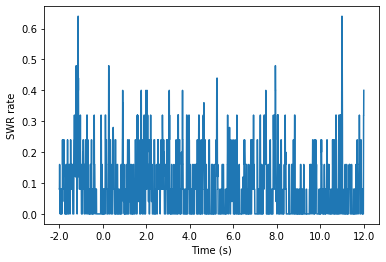

In [609]:
# raw averaged PSTH

print(sub_sess_names[0] + ' to ' + sub_sess_names[-1])
print(ripple_array.shape)
if selected_period == 'whole_retrieval':
    plot(20*np.mean(ripple_array,0))
    xticks(np.arange(0,7000+1,1000),np.arange(-2000/1000,12000/1000+1,2000/1000))
    # ylim(0,0.4)
    xlabel('Time (s)')
    ylabel('SWR rate');

elif selected_period == 'surrounding_recall':
    # start_array,_ = getStartEndArrays(ripple_array)
    # start_array = start_array[:,1:] # artifact of using start_array
    plot(20*np.mean(ripple_array,0))
    xticks(np.arange(0,2000+1,1000),np.arange(-2000/1000,4000/1000+1,2000/1000))
    # ylim(0,0.4)
    xlabel('Time (s)')
    ylabel('SWR rate')
a=1;

## LOCAL run (original program)

In [110]:
## import mne
from scipy.signal import firwin,filtfilt,kaiserord
import pingouin as pg
%autoreload
HPC_labels,ENT_labels,PHC_labels = getMTLregions(MTL_labels)

### PARAMS ###

save_values = 0

selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
# there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period
recall_type_switch = 0    # how do we select recalls?? Numbers 0:3
# 0: Original analysis taking only recalls without a recall in 2 s IRI before them
# 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur
# 2: test condition where we look at second recalls within IRI ONLY
# 3: ISOLATED only!

selected_region = HPC_labels #HPC_labels # ENT_labels+HPC_labels 

remove_soz_ictal = False # False only removes bad electrodes and not soz/ictal
min_ripple_rate = 0.1 # Hz.
max_ripple_rate = 1.5 # Hz.
max_trial_by_trial_correlation = 0.05 # if ripples correlated more than this remove them
max_electrode_by_electrode_correlation = 0.2 #???

filter_type = 'hamming' # 'butter' # Vaz used Butterworth from 80-120 Hz; Norman used Hamming from 70-180 Hz
# •Butterworth from Vaz et al: 2nd order from 80-120 ms, hilbert, select events >2 STD above mean of filtered traces.
#      Events >=25 ms long w/ max amp >3 SD were retained as ripples. Join adjacent ripples separated by <15 ms 
# •Hilbert from Norman et al: "70-180 Hz zero-lag linear-phase Hamming FIR filter w/ transition bandwidth of 5 Hz"
#      Then Hilbert, clip extreme to 4 SD, square this clipped, smooth w/ Kaiser FIR low-pass filter with 40 Hz cutoff,
#      mean and SD computed across entire experimental duration to define the threshold for event detection
#      Events from original (squared but unclipped) signal >4 SD above baseline were selected as candidate SWR events. 
#      Duration expanded until ripple power <2 SD. Events <20 ms or >200 ms excluded. Adjacent events <30 ms separation (peak-to-peak) merged.
# •Using IED detection from Vaz for 250 Hz highpass events (really 250-499). Norman uses 20-60 Hz events which is...odd.
#       See detectRipples code in module for this algorithm


### semantic/temporal clustering parameters ###
min_recalls = 0
PCA_ndim = 1 # number of PC dims to use (Ethan usually found only 1 worked for theta/FC)


# recall params
recall_minimum = 2000 # for isolated recalls what is minimum time for recall to be considered isolated?
IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
retrieval_whole_time = 10000
# encoding params
encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
# these aren't likely to be changed:
desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
eeg_buffer = 300 # buffer to add to either end of IRI when processing eeg #**

### END PARAMS ###

if 'entorhinal' in selected_region and 'left hippocampus' in selected_region:
    region_name = 'HPC_ENT'
elif 'entorhinal' in selected_region:
    region_name = 'ENT'
elif 'left hippocampus' in selected_region:
    region_name = 'HPC'
elif 'parahippocampal' in selected_region:
    region_name = 'PHC'
if selected_period == 'surrounding_recall':
    psth_start = -IRI # only makes sense to look at period <= IRI
    psth_end = IRI # how long to grab data after recall
elif selected_period == 'whole_retrieval':
    psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
    psth_end = IRI+retrieval_whole_time
elif selected_period == 'encoding':
    psth_start = pre_encoding_time
    psth_end = encoding_time

ripple_array = []; fr_array = []; 
trial_nums = []; 
session_ct = 0; channel_ct = 0
HPC_names = []; sub_names = []; sub_sess_names = []
electrodes_per_session = []
total_lists = 0; total_recalls = 0; kept_recalls = 0
align_adjust = 0
ent_elec_ct = []; sd_regions = []; not_sd_regions = []
ripple_ied_accum_ct = []
time_add_save = [];             
encoded_word_key_array = []; serialpos_array = [] # encoding info

trial_by_trial_correlation = []; elec_by_elec_correlation = []
elec_ripple_rate_array = []

channel_coords = []; electrode_labels = []

from sklearn.decomposition import PCA
# see files in semantic_analysis folder to get word lists and PCs
semantic_model = pickle.load(open('/home1/john/SWR/code/semantic_analysis/'+exp+'_wordpool_feats.pk', 'rb')) # dictionary of all exp words
    
semantic_clustering_key = []
temporal_clustering_key = []
serialpos_lags = []
list_trial_nums = []; list_num_key = []
list_level_semantic = []; list_level_temporal = []

for row in sub_df.itertuples(): #sub_df.itertuples():   
    try:
        sub = row.subject; session = row.session; exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        evs = reader.load('task_events')
        evs_free_recall = evs[(evs.type=='REC_WORD')] #& (evs.recalled==True)] # recalled word AND correct (from this list...no instrusions). 
                        # deal with intrusions after checking clustering to ensure removing them doesn't create fake transitions
                                   
        # Order of logic: 1) remove spanish patients 2) remove repeated recalls 
        #      3) make sure at least min_recalls (≥4)  4) get mask of lists to keep so can update evs_free_recall
        #      5) save list of semantic/temporal for every trial
        
        # if not too short or Spanish session, analyze the list
        word_evs = evs[evs['type']=='WORD'] # get words         
        
        session_words = word_evs.item_name.unique()
        if len(findAinB(['BARRO','CABALLO','COSTILLA','DULCE','FICHA','ESTUFA','GALLINA','FRIJOL',
                        'GUARDIA','HILO','JEFE','LABIO','MAIZ','NIEVE','ORO','PALMA','PECHO','PLATO',
                        'RANA','SAPO','SERPIENTE','TALLO','UVA','VIGA','ZAPATO'],session_words))>0:
            break # skip Spanish sessions
        else:
            
            # get good lists to run through
            list_nums = evs_free_recall.list.unique()[evs_free_recall.list.unique()>0] # make sure not a practice list
            no_eeg_lists = evs_free_recall[evs_free_recall.eegoffset == -1].list.unique() # if any recalls in list don't have eeg remove that list
            list_nums = [i for i in list_nums if i not in no_eeg_lists] 
            
            list_mask = []
            temp_semantic_key = []
            temp_temporal_key = []
            temp_serialpos_lags = []
            temp_list_trial_nums = []; temp_list_num_key = []
            temp_list_level_semantic = []; temp_list_level_temporal = []

            for ln in list_nums:
                
                recalls_serial_pos = getSerialposOfRecalls(evs_free_recall,word_evs,ln) # note that intrusions become -999

                # get differences in lags before removing repeats
                list_serialpos_lags = np.append(np.diff(recalls_serial_pos),0) # absolute differences in lags with a 0 at end for last output
            
                # leave intrusions and repeats in for now so can assess clustering with them included
                # ...but still want to know how many legit recalls there are for min_recalls threshold
                temp_serialpos,_ = removeRepeatsBySerialpos(recalls_serial_pos) # remove repeats
                num_true_recalls = len(temp_serialpos[temp_serialpos!=-999])# how many non-intrusions (note that all but 1 -999s removed in last line)
                 
                if num_true_recalls >= min_recalls:
                    list_mask.append(ln) # update kept list mask
                    
                    # now get semantic and temporal values for this list
                    
                    serial_pos = np.array(recalls_serial_pos)-1 # zero index the serialpos
#                     serial_pos = [int(list_words_df[list_words_df['item_name']==w]['serialpos'])-1 for w in list_recalls_df['item_name']] # serialpos starting at 0
                    list_recalls_df = evs_free_recall[evs_free_recall.list==ln] # recalls df just for this list
                    list_words_df = word_evs[word_evs.list==ln] # words df just for this list
        
                    words = list(list_words_df['item_name']) 
                    if 'AXE' in words: # GoogleVec doesn't have this spelling of ax (fix for semantic clustering)
                        list_words_df = list_words_df.replace('AXE','AX')
                        list_recalls_df = list_recalls_df.replace('AXE','AX')
                    
                    # semantic clustering
        
                    if exp == 'FR1':
                        # Decided not to use semantic for FR1 for now but if you do I think FR1_wordpool_feats.pk needs to be recompiled via SWRgetWordList.ipynb 2020-10-19
                        # also should make sure semantic_transition_scores look kosher since made some changes to get_recall_clustering to fix temporal clustering of intrusions
                
                        #Project semantic features for this list to 1 dimension
                        feats = np.array([semantic_model[w] 
                                          for w in list_words_df['item_name']
                                         ])  #construct feature matrix from this list; # WORDs X 300 vecs
                        pca = PCA(n_components=PCA_ndim)
                        pcs = pca.fit_transform(feats) # list of ndim PCs for 12 words

                        # Get semantic cluster transition pairwise values 
                        semantic_transition_scores = np.array(get_recall_clustering(pcs, serial_pos))
                        semantic_list_mean = np.nanmean(semantic_transition_scores[semantic_transition_scores > -990])
                        temp_semantic_key.extend(semantic_list_mean*np.ones(len(list_recalls_df))) # extend by # of recalls for key

                        if len(list_recalls_df)>0:
                            temp_semantic_key[-1] = 'nan' # last recall in every list didn't lead to a transition. So don't give a value
                    elif exp == 'catFR1':
                        # have to use special structure of catFR1 to divide into near v. remote semantic transitions
                        # there's also adjacent v. non-adjacent. so create 2x2 recalls as well as dead ends (no transition from last one)
                        
                        # category numbers to identify semantic transitions
                        item_names = list_recalls_df['item_name']
                        category_nums = [] # don't use list comprehensions so can put -999s in for intrusions
                        for w in item_names:
                            if w in np.array(list_words_df['item_name']):
                                category_nums.append(int(list_words_df[list_words_df['item_name']==w]['category_num']))
                            else:
                                category_nums.append(-999)

                        for recall in np.arange(len(serial_pos)):
                            # it's ok if intrusions or repeats are in here since will be removed later
                            if recall == len(serial_pos)-1: # if last one, no transition happens after this, so put a dummy letter
                                temp_semantic_key.extend('Z')
                            else:
                                transition_dist = np.abs(serial_pos[recall+1]-serial_pos[recall])
                                if transition_dist == 1:
                                    # use single letters and not words since I used extend for FR1 semantic values
                                    if category_nums[recall+1] == category_nums[recall]:
                                        temp_semantic_key.extend('A') # leads to adjacent semantic
                                    else:
                                        temp_semantic_key.extend('B') # leads to adjacent other
                                elif category_nums[recall+1] == -999:
                                    temp_semantic_key.extend('I') # this one leads to an intrusion next
                                elif item_names.iloc[recall] == item_names.iloc[recall+1]:
                                    temp_semantic_key.extend('R') # consecutive repeats
                                else: 
                                    if category_nums[recall+1] == category_nums[recall]:
                                        temp_semantic_key.extend('C') # leads to remote semantic
                                    else:
                                        temp_semantic_key.extend('D') # leads to remote other
                                        
                    # do temporal clustering
                    temporal_transition_scores = np.array(get_recall_clustering(np.arange(len(list_words_df)), serial_pos))
                    # average those values that aren't intrusions/repeats 
                    temporal_list_mean = np.nanmean(temporal_transition_scores[temporal_transition_scores > -990])
                    temp_temporal_key.extend(temporal_list_mean*np.ones(len(list_recalls_df)))
                    if len(list_recalls_df)>0:
                        temp_temporal_key[-1] = 'nan' # last recall in every list didn't lead to a transition. So don't give a value

                    # keep track of lags
                    temp_serialpos_lags.extend(list_serialpos_lags)  
                    
                    # keep track of number of trials in each so can select by minimum later on
                    temp_list_trial_nums.append(len(list_recalls_df))
                    temp_list_num_key.append(ln)
                    
                    # for whole_retrieval analysis need list-level scores for temporal/semantic clustering
                    temp_list_level_temporal.append(temporal_list_mean) # single value for each list
                    if exp == 'FR1':
                        temp_list_level_semantic.append(semantic_list_mean) # they're list_level values for FR1 so just grab first of list
                    else: # for catFR keep list of lists since will have to go through later to assess minimum As or Cs or whatever
                        temp_list_level_semantic.append(temp_semantic_key[-len(serial_pos):]) # grab all of them for this list since will weigh A v B v C v D later
   
        evs_free_recall = evs_free_recall[evs_free_recall.list.isin(list_mask)] # get recalls from qualifying lists
        # need to remove free recalls that happened more than once (list_mask doesn't account for these)        
#         evs_free_recall = removeRepeatedRecalls(evs_free_recall,word_evs)
#         evs_free_recall = evs_free_recall[evs_free_recall.eegoffset > -1]
      
        # select which recalls??         
        [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)
        
        # now have recalls you want after including intrusions and repeats for clustering & IRI purposes
        # ...so remove them and update selected_recall_idxs (since this is key to select clustering values down below)
        _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs)
        nonintrusion_idxs = np.array(evs_free_recall.intrusion==0)

        selected_recalls_idxs = selected_recalls_idxs & (nonrepeat_indicator>0) & nonintrusion_idxs
        
        evs_free_recall = evs_free_recall[selected_recalls_idxs]
        
        if len(evs_free_recall)==0:
            break

        pairs = reader.load('pairs')
        try:
            localizations = reader.load('localization')
        except:
            localizations = []
        tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
        elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs) 
        
#         # count elec regions with specific string...mostly here to comment out below and test for good sessions
#         if len(findAinB(ENT_labels,elec_regions))>0:
#             ent_ct = len(findAinB(ENT_labels,elec_regions))
#             ent_elec_ct = np.append(ent_elec_ct,sub+'_'+str(session)+'_ct-'+str(ent_ct))

        # load eeg
        adjustment = 0
        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall
            
        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
#             evs_rets = evs_rets[evs_rets.eegoffset>-1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 
#             evs_rets = evs_rets[evs_rets.list>-1] # remove practice lists
            # in clustering I make a list_mask, so use that to select which trials to get EEG for
            evs_rets = evs_rets[evs_rets.list.isin(list_mask)]
            eeg_events = evs_rets
            
            # get alignmnet of end of beep time to EEG so can align retrieval to end of beep across all sessions
#             align_adjust = getRetrievalStartAlignmentCorrection(sub,session,exp) # in ms

        elif selected_period == 'encoding':
            # I'm going to save encoding word events too, but need a mask to keep track of:
            # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
            evs_encoding_words = evs[evs.type=='WORD']
            evs_encoding_words = evs_encoding_words[evs_encoding_words.eegoffset>-1]
            encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
            encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
            encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
            # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
            eeg_events = evs_encoding_words
            
        # fixing bad trials
        if sub == 'R1045E': # this one session has issues in eeg trials past these points so remove events
            
            break # too difficult to deal with for clustering analysis
                        
            if selected_period == 'surrounding_recall':
                eeg_events = eeg_events.iloc[:65,:] # only the first 66 recalls have good eeg
            elif selected_period == 'whole_retrieval':
                eeg_events = eeg_events.iloc[:20,:] # only the first 20 retrieval periods have good eeg
            elif selected_period == 'encoding':
                eeg_events = eeg_events.iloc[:263,:] # same idea
                encoded_word_key = encoded_word_key[:263]
                
        # fix EEG offset due to Unity implementation error
        
#         init_time = eeg_events.iloc[0].eegoffset
        eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)
#         print(sub+'-'+str(session)+'-'+exp+': '+str(eeg_events.iloc[0].eegoffset-init_time))

        # note I added the align_adjust now for whole_retrieval where I adjust all retrieval starts to beep_end
        eeg = reader.load_eeg(events=eeg_events, rel_start=int(psth_start-eeg_buffer+align_adjust), 
                              rel_stop=int(psth_end+eeg_buffer+align_adjust), clean=True, scheme=pairs) #**

        # events X electrodes X time
        sr = eeg.samplerate

        # if weird samplerate, add a few ms to make the load work
        if (499<sr<500) | (998<sr<1000):
            time_add = 1
            if (499<sr<500):
                sr = 500
            elif (998<sr<1000):
                sr = 1000
            while eeg.shape[2] < (psth_end-psth_start+2*eeg_buffer)/(1000/sr):
                eeg = reader.load_eeg(events=eeg_events, rel_start=int(psth_start-eeg_buffer+align_adjust), 
                                      rel_stop=int(psth_end+eeg_buffer+time_add+align_adjust), clean=True, scheme=pairs)
                if time_add>50: #**
                    break
                time_add+=1
            time_add_save.append(time_add)
            eeg.samplerate = sr # need to overwrite those that were just fixed
        
        eeg_ptsa = eeg.to_ptsa()
        eeg = None # clear variable
#         break;break;break # to look at eeg_ptsa (plots at bottom of notebook) before filtering

        # line removal...don't do 120 for now
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()
                
        ## FILTERS ##
        trans_width = 5. # Width of transition region, normalized so that 1 corresponds to pi radians/sample. 
        # That is, the frequency is expressed as a fraction of the Nyquist frequency.
        ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sr/trans_width) # gives 400 with sr=500, trans=5
        if sr == 512 or sr == 1024 or sr == 1023.999: # last one fixes R1221P:
            ntaps = np.ceil(ntaps)
        FIR_bandstop = firwin(int(ntaps+1), [70.,178.], fs=sr, window='hamming',pass_zero='bandstop')
    #     FIR_bandpass = firwin(int(ntaps), [70.,180.], fs=sr, window='hamming',pass_zero='bandpass')
        bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED
    #     bandstop_60_80 = firwin(int(ntaps+1), [60.,80.], fs=sr, window='hamming',pass_zero='bandstop') # Gelinas 2016 IED
        nyquist = sr/2
        ntaps40, beta40 = kaiserord(40, trans_width/nyquist)
        kaiser_40lp_filter = firwin(ntaps40, cutoff=40, window=('kaiser', beta40), scale=False, nyq=nyquist, pass_zero='lowpass')

        # filter for ripples using filter selected above

        if filter_type == 'hamming':
            # need to subtract out to get the filtered signal since default is bandstop but want to keep it as PTSA        
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop,1.,eeg_ptsa) 
            #         eeg_rip_band = filtfilt(FIR_bandpass,1.,eeg_ptsa) # can't use ptsa_to_mne this way so use eeg-bandstopped signal
            eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa)

        elif filter_type == 'butter':
            eeg_rip_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
            if sr == 500: # dropped below 250 Hz because too close Nyquist
                eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=200., filt_type='highpass',order=2).filter() 
            elif sr >= 1000:    
                #this seems okay since large range far from Nyquist...problem is it likely misses key events
                eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[250.,499.], filt_type='bandpass',order=2).filter()
            eeg_raw = ptsa_to_mne(eeg_ptsa,[0,psth_end-psth_start+2*eeg_buffer])    #**       
#         eeg_ptsa = None # no reason to clear in local version

        eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
        _ = eeg_rip_band.apply_hilbert(envelope=True)
        eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
        _ = eeg_ied_band.apply_hilbert(envelope=True)
        
        # get bad channel mask
        try:
            elec_cats = reader.load('electrode_categories') # this is cool
        except:
            if remove_soz_ictal == True:
                e = 'No electrode categories for '+sub+', session '+str(session)
                LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                continue
            else:
                elec_cats = []
            
        bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)
        
        # remove bad range of electrodes. Typically bipolar pairs with same electrodes showing same signal
        # across channels (which is often noisy things like mvoement artifacts)
        electrode_search_range = range(len(elec_regions))
        if exp == 'FR1':
            if sub == 'R1120E':
                electrode_search_range = range(30) # HPC elecs after 25:26 have lots of artifacts that get picked up as SWRs. See subject figure PPT
            elif sub == 'R1349T': # channels 90 and below have tons of artifcats. After that looks okay though
                electrode_search_range = range(91,len(elec_regions))
            elif sub == 'R1397D': # for these two sessions two pairs of the electrodes have lots of correlated noise. Remove them
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 60]
                electrode_search_range.remove(110)
            elif sub == 'R1332M' and session == 1:
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 48] # some real weird bands in these couple sessions
                electrode_search_range.remove(49)
            elif sub == 'R1299T':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 34] # see PPT. These two pairs shared an electrode and had tons of correlated artifacts
                electrode_search_range.remove(43)
        # note that I'm okay with overlap in say entorhinal also removing hippocampal channels. So don't specify region in these
        # just assume that the overlap exists in all cases
        elif exp == 'catFR1':
            if sub == 'R1269E':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 11] # 10, 11, 54, 55 all look identical in HPC raster so remove latter 3
                electrode_search_range.remove(54) # (see SWR catFR1 problem sessions ppt for details)
                electrode_search_range.remove(55)
            elif sub == 'R1328E':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 38] # overlapping signal with ch 37
            elif sub == 'R1367D':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 71] # overlapping signals with neighbor
                electrode_search_range.remove(96)
            elif sub == 'R1397D':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 110]
                electrode_search_range.remove(60) 
            elif sub == 'R1405E' and mont==0:
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 44]
            elif sub == 'R1405E' and mont==1:
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 79]
            elif sub == 'R1447M': # overlapping with neighbors. again documented in SWR catFR1 problem sessions ppt 
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 15]
                electrode_search_range.remove(17)
            elif sub == 'R1469D':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 16]
            elif sub == 'R1489E':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 3] # first entorhinal...see catFR1 prob session ppt
                electrode_search_range.remove(55)
            elif sub == 'R1400N':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 39] # entorhinal...middle of 3 consecutive channels
            elif sub == 'R1190P':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 96] # entorhinal...3rd of 4 consecutive channels
            elif sub == 'R1092J':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 39] # entorhinal...3rd of 4 consecutive channels
            elif sub == 'R1028M':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 8] # entorhinal...3rd of 4 consecutive channels
            elif sub == 'R1107J':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 3] # parahippocampal...4th of 5 consecutive channels
            elif sub == 'R1364C':
                electrode_search_range = [i for i in range(len(elec_regions)) if i != 60] # parahippocampal...3rd of 4 consecutive channels

        region_electrode_ct = 0
        session_ripple_rate_by_elec = [];
        for channel in electrode_search_range:
            if (elec_regions[channel] in selected_region) & \
            (bad_bp_mask[channel] == 0): # don't use bad electrodes
                # get data from MNE container 
                eeg_rip = eeg_rip_band.get_data()[:,channel,:]     
                eeg_ied = eeg_ied_band.get_data()[:,channel,:]

                # select detection algorithm (note that iedlogic is same for both so always run that)
                
                if filter_type == 'hamming':
                    # filter IEDs 
                    eeg_ied = eeg_ied**2 # already rectified now square
                    eeg_ied = filtfilt(kaiser_40lp_filter,1.,eeg_ied) # low pass filter  
                    mean1 = np.mean(eeg_ied)
                    std1 = np.std(eeg_ied)
                    iedlogic = eeg_ied>=mean1+4*std1 # Norman et al 2016                
                    # detect ripples
                    ripplelogic = detectRipplesHamming(eeg_rip,trans_width,sr,iedlogic)
                elif filter_type == 'butter':
                    eeg_mne = eeg_raw.get_data()[:,channel,:]
                    # detect ripples
                    ripplelogic, iedlogic = detectRipplesButter(eeg_rip,eeg_ied,eeg_mne,sr)             

#                 ripple_ied_accum_ct.append([sub,session,sr,sum(ripplelogic),sum(iedlogic),sum(ripplelogic2),sum(iedlogic2),
#                                             sum(ripplelogic_enc),sum(iedlogic_enc)])

                if sr>desired_sample_rate: # downsampling here for anything greater than 500
                    ripplelogic = downsampleBinary(ripplelogic,sr/desired_sample_rate)
            
                # ripples are detected, so can remove buffers now #**
                ripplelogic = ripplelogic[:,int(eeg_buffer/(1000/desired_sample_rate)):
                                          int((psth_end-psth_start+eeg_buffer)/(1000/desired_sample_rate))]

                # skip this electrode if the ripple rate is below threshold
                temp_start_array,_ = getStartEndArrays(ripplelogic)
                elec_ripple_rate = sum(temp_start_array)/temp_start_array.shape[0]/((psth_end-psth_start)/1000)
                if elec_ripple_rate < min_ripple_rate:
                    print(sub+', '+str(session)+' skipped b/c below ripple rate thresh for ch.: '+str(channel))
                    continue
                elif elec_ripple_rate > max_ripple_rate:
                    print(sub+', '+str(session)+' skipped b/c ABOVE ripple rate thresh for ch.: '+str(channel))
                    continue # skip this electrode
    
                # check the ripples for this electrode and make sure they're not super correlated across trials

                # first, bin the array so can get more realistic correlation not dependent on ms timing
                binned_ripplelogic = downsampleBinary(ripplelogic,10) # downsample by 10x so 10 ms bins
                trial_ripple_df = pd.DataFrame(data=np.transpose(binned_ripplelogic))
                num_cols = len(list(trial_ripple_df))
                trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
                temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)
                if temp_tbt_corr > max_trial_by_trial_correlation:
                    print(sub+', '+str(session)+' skipped b/c above trial-by-trial correlation for ch.: '+str(channel))
                    continue

                ## if this electrode passes SAVE data ##
                
                if selected_period == 'surrounding_recall':
                    if len(np.array(temp_semantic_key)[selected_recalls_idxs]) != len(ripplelogic):
                        # eegoffsets with -1 should be removed above anyway but keep as a check
                        break # sys.exit()
                
                trial_by_trial_correlation.append(temp_tbt_corr) # corr b/w trials
                elec_ripple_rate_array.append(elec_ripple_rate) # record the average ripple rate for this electrode
                
                # append arrays across electrodes
                ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
                session_ripple_rate_by_elec = superVstack(session_ripple_rate_by_elec,np.mean(binned_ripplelogic,0)) # for correlation b/w elecs below
                
                if selected_period == 'encoding':
                    encoded_word_key_array.append(encoded_word_key) # save the key for each electrode so easier to unpack later
                    serialpos_array.append(evs_encoding_words.serialpos)
                    if len(encoded_word_key) != ripplelogic.shape[0]:
                        e = 'Encoded word key and ripple_array dont match for '+sub+str(session)+'_'+str(channel)
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                        
                if selected_period == 'whole_retrieval':
                    # make a matrix of the times of free recall if looking at whole retrieval period
                    list_nums = evs_rets.list.unique() # count all list numbers for this session
                    temp_fr_array = np.zeros((len(list_nums),retrieval_whole_time),dtype=np.int8)
                    for ln in list_nums:
                        list_times = np.array(evs_free_recall[evs_free_recall.list==ln].mstime) - \
                                    (np.array(evs_rets[evs_rets.list==ln].mstime) + align_adjust) # align all times to end of beep
#                         list_times = evs_free_recall[evs_free_recall.list==ln].rectime # I confirmed these are accurate relative to REC_START
                        for i,list_time in enumerate(list_times):
                            if list_time <= retrieval_whole_time:
                                # used to do ln-1 instead of i to get order opposite but doesn't work now since I remove lists
                                temp_fr_array[i][int(np.round(list_time))] = 1 
                    fr_array = superVstack(fr_array,temp_fr_array)
                    
                semantic_clustering_key.extend(np.array(temp_semantic_key)[selected_recalls_idxs])
                temporal_clustering_key.extend(np.array(temp_temporal_key)[selected_recalls_idxs])
                serialpos_lags.extend(np.array(temp_serialpos_lags)[selected_recalls_idxs])
                
                # record list-level numbers (for whole_retrieval analysis)
                list_trial_nums.extend(temp_list_trial_nums) 
                list_num_key.extend(temp_list_num_key)
                list_level_temporal.extend(temp_list_level_temporal)
                list_level_semantic.extend(temp_list_level_semantic)
                
                channel_ct+=1 # total channels from beginning 
                region_electrode_ct+=1 # channel ct for this session
                HPC_names.append(elec_regions[channel])
                sub_names.append(sub)
                sub_sess_names.append(sub+'-'+str(session))
                print('Cumulative array size after channel: '+str(channel))
                print(ripple_array.shape)
                trial_nums = np.append(trial_nums,ripplelogic.shape[0])
                electrode_labels.append(pairs.iloc[channel].label) # get names of electrodes so can look for them across sessions
                
                # get atlas coordinates for this electrode
                if 'avg.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['avg.x'],np.append(pairs.iloc[channel]['avg.y'],pairs.iloc[channel]['avg.z']))
                elif 'ind.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['ind.x'],np.append(pairs.iloc[channel]['ind.y'],pairs.iloc[channel]['ind.z']))
                else:
                    temp_coord = np.empty(3); temp_coord[:] = np.nan
                channel_coords.append(temp_coord)
                      
        # before we keep all the electrodes in this session, remove electrodes that are highly correlated.
        # this really only makes sense for the cluster version, since I only do a session at a time here
        if np.sum(session_ripple_rate_by_elec)>0 and region_electrode_ct>1:
            session_ripple_df = pd.DataFrame(data=np.transpose(session_ripple_rate_by_elec))
            num_cols = len(list(session_ripple_df))
            session_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
#             print(pg.pairwise_corr(session_ripple_df,method='spearman').r) # print the elec-by-elec correlations
            elec_by_elec_correlation = np.mean(pg.pairwise_corr(session_ripple_df,method='spearman').r) # correlation b/w elecs
            if elec_by_elec_correlation > max_electrode_by_electrode_correlation:
                print('Correlation b/w electrodes too high, corr = '+str(elec_by_elec_correlation))
            else:
                print('good set of electrodes (not correlated with each other)')

        electrodes_per_session = np.append(electrodes_per_session,region_electrode_ct)
        session_ct+=1
        
    except Exception as e:
        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt') #np.save('SWRscript_FR1.npy', ['Exception', str(e.__class__), str(e)])
        continue

# csvWriter(ripple_ied_accum_ct,'ieds') # if you want to save the accumulated ripple numbers

if save_values == 1:
    if remove_soz_ictal == False:
        soz_label = 'soz_in'
    else:
        soz_label = 'soz_out'
    if session_ct == 1:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    else:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    with open(fn,'wb') as f:
        pickle.dump({'channel_ct':channel_ct, 'session_ct':session_ct,
                    'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                    'ripple_array':ripple_array, #'ripple_array2':ripple_array2, 'ripple_array_enc':ripple_array_enc,
                    'trial_nums':trial_nums, #'trial_nums2':trial_nums2,'trial_nums_enc':trial_nums_enc,
                    'fr_array':fr_array, 'sub_names':sub_names, 
                    'encoded_word_key_array':encoded_word_key_array,'serialpos_array':serialpos_array,
                    'total_recalls':total_recalls, 'kept_recalls':kept_recalls,
                    'trial_by_trial_correlation':trial_by_trial_correlation,'elec_ripple_rate_array':elec_ripple_rate_array,
                    'semantic_clustering_key':semantic_clustering_key,'temporal_clustering_key':temporal_clustering_key,
                    'serialpos_lags':serialpos_lags, 
                    'list_trial_nums':list_trial_nums, 'list_num_key':list_num_key,
                    'list_level_semantic':list_level_semantic, 'list_level_temporal':list_level_temporal,
                    'electrode_labels':electrode_labels,'channel_coords':channel_coords}, f)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


--Call--
> /home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/IPython/core/displayhook.py(252)__call__()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.



ipdb>  u


> <ipython-input-110-d0b22759dc97>(253)<module>()
    252         nonintrusion_idxs = np.array(evs_free_recall.intrusion==0)
--> 253         import ipdb; ipdb.set_trace()
    254         selected_recalls_idxs = selected_recalls_idxs & (nonrepeat_indicator>0) & nonintrusion_idxs



ipdb>  l


    248 
    249         # now have recalls you want after including intrusions and repeats for clustering & IRI purposes
    250         # ...so remove them and update selected_recall_idxs (since this is key to select clustering values down below)
    251         _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs)
    252         nonintrusion_idxs = np.array(evs_free_recall.intrusion==0)
--> 253         import ipdb; ipdb.set_trace()
    254         selected_recalls_idxs = selected_recalls_idxs & (nonrepeat_indicator>0) & nonintrusion_idxs
    255 
    256         evs_free_recall = evs_free_recall[selected_recalls_idxs]
    257 
    258         if len(evs_free_recall)==0:



ipdb>  selected_recalls_idxs


array([ True, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True, False, False,  True,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
        True,  True, False, False,  True,  True,  True, False, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True, False,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True, False,
       False,  True, False,  True, False,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True, False, False,  True, False,  True,
        True, False,  True,  True, False, False,  True, False, False,
        True, False,

ipdb>  temp_semantic_key


['I', 'I', 'D', 'D', 'A', 'Z', 'A', 'C', 'I', 'I', 'Z', 'D', 'A', 'I', 'D', 'A', 'C', 'Z', 'A', 'I', 'I', 'D', 'I', 'D', 'I', 'Z', 'I', 'I', 'D', 'C', 'A', 'D', 'Z', 'I', 'I', 'D', 'D', 'C', 'A', 'Z', 'I', 'D', 'D', 'I', 'I', 'I', 'I', 'D', 'Z', 'I', 'Z', 'A', 'C', 'B', 'I', 'I', 'D', 'Z', 'R', 'I', 'D', 'C', 'C', 'Z', 'A', 'I', 'I', 'I', 'I', 'Z', 'I', 'I', 'D', 'I', 'I', 'D', 'Z', 'D', 'I', 'D', 'I', 'Z', 'I', 'D', 'I', 'I', 'Z', 'C', 'B', 'C', 'D', 'Z', 'D', 'I', 'I', 'D', 'I', 'Z', 'I', 'D', 'A', 'C', 'Z', 'C', 'I', 'I', 'I', 'I', 'Z', 'I', 'I', 'D', 'I', 'Z', 'C', 'I', 'D', 'I', 'I', 'Z', 'I', 'I', 'I', 'I', 'I', 'Z', 'C', 'D', 'I', 'I', 'Z', 'I', 'I', 'I', 'Z', 'A', 'C', 'B', 'Z', 'A', 'I', 'D', 'Z']


ipdb>  temp_semantic_key[selected_recalls_idxs]


*** TypeError: only integer scalar arrays can be converted to a scalar index


ipdb>  np.array(temp_semantic_key)[selected_recalls_idxs]


array(['I', 'D', 'A', 'A', 'C', 'I', 'I', 'Z', 'D', 'D', 'A', 'C', 'Z',
       'A', 'I', 'I', 'I', 'Z', 'I', 'D', 'D', 'Z', 'I', 'I', 'D', 'D',
       'C', 'A', 'I', 'D', 'I', 'I', 'I', 'I', 'Z', 'A', 'I', 'D', 'Z',
       'R', 'I', 'D', 'C', 'C', 'A', 'I', 'I', 'Z', 'I', 'I', 'I', 'I',
       'Z', 'D', 'I', 'D', 'I', 'I', 'Z', 'C', 'C', 'Z', 'D', 'I', 'I',
       'D', 'Z', 'I', 'D', 'A', 'Z', 'C', 'I', 'I', 'I', 'I', 'I', 'D',
       'C', 'D', 'I', 'Z', 'I', 'I', 'C', 'I', 'I', 'Z', 'I', 'I', 'I',
       'A', 'C', 'B', 'Z', 'A', 'D', 'Z'], dtype='<U1')


ipdb>  q


2020-11-20_00-41-37: DF Exception: Sub: R1303E, Sess: 0, BdbQuit, , file: <ipython-input-110-d0b22759dc97>, line no: 253


In [25]:
# some debugging checks with breakpoint in removeRepeatedRecalls
nonrepeat_indicator
np.array(evs_free_recall.list)
np.array(evs_free_recall[evs_free_recall.list==13].serialpos)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1.])

array([ 1,  1,  2,  3,  3,  3,  4,  5,  6,  6,  6,  7,  8,  8,  8,  9,  9,
       10, 11, 11, 11, 12, 12, 12, 12])

array([], dtype=int64)

## load LOCAL data if didn't just run above:

In [192]:
%autoreload
# load params
session_ct = 21; sub_num = 8; region_name = 'HPC' #'ENT' #'HPC_ENT' #'HPC'
# session_ct = 13; sub_num = 6; region_name='HPC' # load for initial 6 HPC test subs
# session_ct = 9; sub_num = 5; region_name = 'ENT'; # 5 initial subjects with ERC regions
# session_ct = 1; sub_num = 1; filter_type = 'hamming'; sub = 'R1010J' # sub='R1112M'
# session_ct = 5; sub_num = 2; filter_type = 'hamming' # ['R1010J','R1112M'] initial 2
remove_soz_ictal = False
selected_period = 'surrounding_recall'
recall_selection_name = ''

recall_selection_name = ''
if recall_type_switch == 1:
    recall_selection_name = 'FIRSTOFCOMPOUND'
elif recall_type_switch == 2:
    recall_selection_name = 'RECALLTWO'
elif recall_type_switch == 3:
    recall_selection_name = 'SOLONOCOMPOUND'

if remove_soz_ictal == False:
    soz_label = 'soz_in'
else:
    soz_label = 'soz_out'
if session_ct == 1:
    fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(sub_num)+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
else:
    fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(sub_num)+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p') 
with open(fn,'rb') as f:
    dat = pickle.load(f)
    ripple_array = dat['ripple_array']; session_ct = dat['session_ct']
    HPC_names = dat['HPC_names']; sub_sess_names = dat['sub_sess_names']
    channel_ct = dat['channel_ct']; #ripple_array2 = dat['ripple_array2']
    trial_nums = dat['trial_nums']; #trial_nums2 = dat['trial_nums2']
    fr_array = dat['fr_array']; sub_names = dat['sub_names']; encoded_word_key_array = dat['encoded_word_key_array']
    total_recalls = dat['total_recalls']; kept_recalls = dat['kept_recalls']
    trial_by_trial_correlation = dat['trial_by_trial_correlation']; elec_ripple_rate_array = dat['elec_ripple_rate_array']
    

array([-1.34379222e-02, -1.88687325e-02,  1.18858263e-02, -1.31486102e-02,
        1.33176374e-02,  5.53236936e-03,  3.03765253e-02,  6.69768828e-03,
       -8.51419202e-03, -5.42858383e-04,  8.65486826e-03,  3.83609199e-03,
       -4.86472574e-03, -7.97323334e-04, -3.00349346e-03,  3.68884328e-04,
        5.72784433e-03, -1.55206100e-03, -1.61628431e-03,  7.85200932e-04,
        9.75126758e-04, -6.83038526e-06, -5.45612908e-04,  3.07179482e-03,
       -2.12824571e-03,  4.45713615e-04,  1.07095357e-04,  2.88585394e-03,
       -1.24909830e-03, -3.63532441e-03,  3.23105049e-03, -7.01663765e-04,
        2.09122371e-03, -1.20559381e-03,  3.10552034e-03, -1.79087136e-03,
       -4.18595763e-04, -6.46334222e-03, -4.63312401e-03, -1.10276541e-03,
       -4.04639553e-03, -6.60540981e-03, -8.76163129e-04,  2.68194179e-03,
        2.17746857e-04,  5.65410791e-04,  6.61923678e-03,  4.72941420e-04,
        1.27349662e-03,  5.23590558e-03, -4.33183769e-04,  9.73200308e-03,
        5.77542355e-03, -

array([0.25      , 0.47222222, 0.55555556, 0.25      , 0.27777778,
       0.22222222, 0.19444444, 0.33333333, 0.12962963, 0.30555556,
       0.25925926, 0.35185185, 0.23880597, 0.3880597 , 0.24253731,
       0.26865672, 0.21641791, 0.35447761, 0.31343284, 0.37313433,
       0.26865672, 0.27238806, 0.45895522, 0.40298507, 0.47014925,
       0.51492537, 0.54104478, 0.49253731, 0.55970149, 0.17567568,
       0.26351351, 0.30405405, 0.21621622, 0.18243243, 0.37837838,
       0.39864865, 0.34459459, 0.31081081, 0.22297297, 0.48648649,
       0.42567568, 0.2972973 , 0.41891892, 0.49324324, 0.53378378,
       0.66216216, 0.265625  , 0.40625   , 0.3046875 , 0.296875  ,
       0.2734375 , 0.46875   , 0.46875   , 0.3359375 , 0.3203125 ,
       0.296875  , 0.4921875 , 0.5390625 , 0.4296875 , 0.640625  ,
       0.5390625 , 0.3984375 , 0.6640625 , 0.25862069, 0.42241379,
       0.29310345, 0.22413793, 0.35344828, 0.4137931 , 0.37931034,
       0.45689655, 0.28448276, 0.23275862, 0.51724138, 0.48275

array([ 0.05597759,  0.06561473,  0.02897647,  0.03651452,  0.03659807,
        0.0104805 ,  0.13832835,  0.04341697,  0.19525208,  0.0934744 ,
        0.15099387,  0.10057197, -0.01598743,  0.02944021,  0.06277056,
        0.07300544,  0.05752211, -0.00883884,  0.12614315, -0.09336898,
        0.11350296,  0.06751996,  0.09412214, -0.01037603,  0.05178957,
        0.1001404 ,  0.0085441 ,  0.1754628 , -0.02029069,  0.03980972,
        0.17460547,  0.06048908,  0.03430159,  0.02404261,  0.05480015,
       -0.0150322 ,  0.02676009,  0.03488396,  0.02329786, -0.02515134,
       -0.07632766, -0.06041815,  0.07222378,  0.18463846, -0.00851147,
       -0.00841051,  0.0948831 ,  0.03115211,  0.04307173, -0.00583415,
        0.02135248,  0.04794127,  0.02014327,  0.04795773,  0.09574192,
        0.06122856,  0.13993658,  0.09724409,  0.03538052,  0.07515885,
        0.06718553, -0.05217009, -0.03638378, -0.0232042 ,  0.02131183,
       -0.00074817,  0.00241541,  0.00929279,  0.15678985,  0.19

(array([  0.,   0.,   0.,   0.,   0.,   1.,   7.,  25.,  79., 143., 145.,
         40.,   9.,  13.,   5.,   0.,   0.,   0.,   0.]),
 array([-1.00000000e-01, -9.00000000e-02, -8.00000000e-02, -7.00000000e-02,
        -6.00000000e-02, -5.00000000e-02, -4.00000000e-02, -3.00000000e-02,
        -2.00000000e-02, -1.00000000e-02, -5.55111512e-17,  1.00000000e-02,
         2.00000000e-02,  3.00000000e-02,  4.00000000e-02,  5.00000000e-02,
         6.00000000e-02,  7.00000000e-02,  8.00000000e-02,  9.00000000e-02]),
 <a list of 19 Patch objects>)

Text(0.5, 0, 'Trial by trial correlation')

Text(0, 0.5, 'Electrode count')

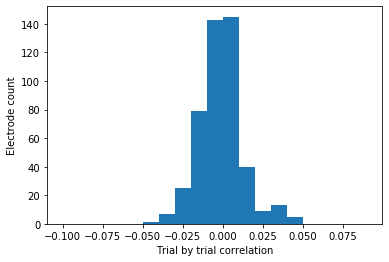

(array([ 0.,  0., 55., 54., 44., 75., 37., 34., 36., 32., 29., 27., 10.,
        13.,  8., 10.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95]),
 <a list of 39 Patch objects>)

Text(0.5, 0, 'Ripple rate (hz)')

Text(0, 0.5, 'Electrode count')

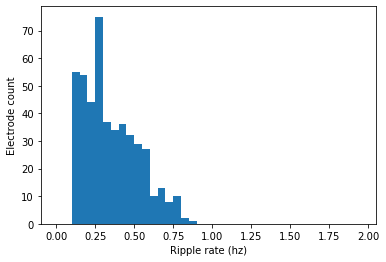

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,
        10.,  9., 16., 14., 10.,  5.,  5.,  4.,  5.,  0.,  0.,  0.,  0.,
         0.]),
 array([-3.50000000e-01, -3.25000000e-01, -3.00000000e-01, -2.75000000e-01,
        -2.50000000e-01, -2.25000000e-01, -2.00000000e-01, -1.75000000e-01,
        -1.50000000e-01, -1.25000000e-01, -1.00000000e-01, -7.50000000e-02,
        -5.00000000e-02, -2.50000000e-02,  3.33066907e-16,  2.50000000e-02,
         5.00000000e-02,  7.50000000e-02,  1.00000000e-01,  1.25000000e-01,
         1.50000000e-01,  1.75000000e-01,  2.00000000e-01,  2.25000000e-01,
         2.50000000e-01,  2.75000000e-01,  3.00000000e-01,  3.25000000e-01]),
 <a list of 27 Patch objects>)

Text(0.5, 0, 'Elec by elec correlation')

Text(0, 0.5, 'Electrode count')

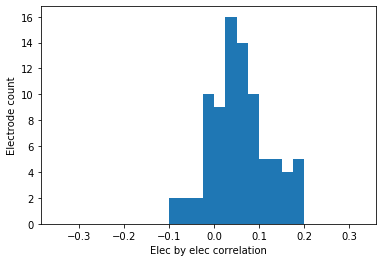

In [54]:
# to visualize the removal parameters
np.array(trial_by_trial_correlation)
np.array(elec_ripple_rate_array)
np.array(elec_by_elec_correlation)
plt.hist(trial_by_trial_correlation,np.arange(-0.1,0.1,0.01)); xlabel('Trial by trial correlation'); ylabel('Electrode count'); show()
plt.hist(elec_ripple_rate_array,np.arange(0,2,0.05)); xlabel('Ripple rate (hz)'); ylabel('Electrode count'); show()
plt.hist(elec_by_elec_correlation,np.arange(-0.35,0.35,0.025)); xlabel('Elec by elec correlation'); ylabel('Electrode count'); show()

# recalls:
19963
TEMPORAL CLUSTERING
75th percentile score: 
0.6974206349206349
25th percentile score: 
0.45482804232804236


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


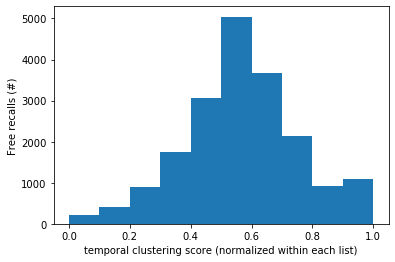

SEMANTIC CLUSTERING
75th percentile score: 
0.7583333333333333
25th percentile score: 
0.5596938775510204


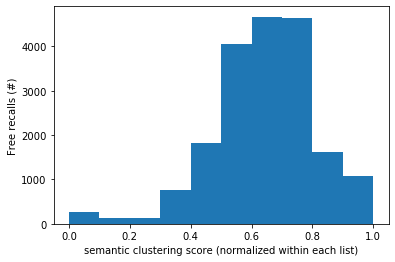

In [13]:
# some clustering numbers (using the older method of percentiles for each)
from scipy.stats import scoreatpercentile
print('# recalls:'); print(len(temporal_clustering_key))
hist(temporal_clustering_key)
ylabel('Free recalls (#)')
xlabel('temporal clustering score (normalized within each list)')
print('TEMPORAL CLUSTERING')
print('75th percentile score: ');print(scoreatpercentile(temporal_clustering_key,75))
print('25th percentile score: ');print(scoreatpercentile(temporal_clustering_key,25))

show()
hist(semantic_clustering_key)
ylabel('Free recalls (#)')
xlabel('semantic clustering score (normalized within each list)')
print('SEMANTIC CLUSTERING')
print('75th percentile score: ');print(scoreatpercentile(semantic_clustering_key,75))
print('25th percentile score: ');print(scoreatpercentile(semantic_clustering_key,25))
a=1;

## Recall period: Get start_array and select subfield if HPC

In [304]:
## DO YOU WANT TO SELECT A SUBFIELD OR CLUSTER METHOD?? ##  

# Note: if you want to change a parameter in here after running you need to reload above

select_subfield = True 

if select_subfield == True:
    location_selected = ['ca1','dg'] # 'ca3' # 'dg' 'ca1' 'sub' ['ca1','dg']<-can select 2 like this as well (code looks for both)
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''

select_semantic_temporal = 0
# 0 means neither (use for no clustering or subject-level), 
# 1 means semantic 
# 2 means temporal
# commandeered this framework for 3: temporal by lag. There upper/lower actually means lag=1 and lag≥3

catFR1_all_semantic = 1  # for catFR1: if 1 testing all semantic trials; if 0 use only remote

# if selecting for semantic/temporal clustering subset of trials pick your subset
upper_or_lower = 0

## For FR1: ##
# 1 means higher than upper_percentile (clustered) 
# 2 means lower than lower (unclustered)
# 0 means nothin...use for subject_level plots
# for trial_lag (3 above for select_semantic_temporal) upper_or_lower=1 means lag==1 and =2 means ≥4

## For catFR1: ##
# 1 means all semantically clustered (adjacent AND remote semantic transitions), i.e. A&B
# 2 means all other except adjacent non-semantic (remote non-semantic and dead ends), i.e. D&Z

# upper_percentile = 0.75;  lower_percentile = 0.25
upper_percentile = 0.5;  lower_percentile = 0.5
    
desired_sample_rate = 500.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print('Trial sum = '+str(np.sum(trial_nums)))
# print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))

start_array,end_array = getStartEndArrays(ripple_array) # get start array


## select by clustering scores!!! ## 
from scipy.stats import scoreatpercentile

# select cluster method
if select_semantic_temporal == 1: # semantic!
    selection_name = 'SEMANTIC'
    sorting_values = semantic_clustering_key
elif select_semantic_temporal == 2: # temporal!
    selection_name = 'TEMPORAL'   
    sorting_values = temporal_clustering_key
elif select_semantic_temporal == 3: # temporal by lag!
    selection_name = 'TEMPORAL_LAG'
    sorting_values = np.abs(serialpos_lags)
else:
    selection_name = 'ALL'    
    sorting_values = np.ones(len(temporal_clustering_key))    
  
    
# select subset of recalls
if upper_or_lower == 1:
    above_or_below = 'above'
    percentile = upper_percentile
elif upper_or_lower == 2:
    above_or_below = 'below'
    percentile = lower_percentile
else:
    above_or_below = ''
    percentile = ''
    
# first get the subject_name_array
subject_name_array,session_name_array,electrode_array,channel_coords_array = getSubSessPredictors(sub_names,sub_sess_names,
                                                                            trial_nums,electrode_labels,channel_coords)

# select recalls based on clustering
if exp == 'catFR1' and select_semantic_temporal == 1:
    if upper_or_lower == 1: # semantic clustering
        if catFR1_all_semantic == 1:
            selected_recalls = (np.array(sorting_values) == 'A') | (np.array(sorting_values) == 'C') # all clustered
        else:
            selected_recalls = np.array(sorting_values) == 'C' # clustered remote#         
    elif upper_or_lower == 2: # non-semantic trials
        if catFR1_all_semantic == 1:
            selected_recalls = (np.array(sorting_values) == 'B') | (np.array(sorting_values) == 'D') # all unclustered
        else:
            selected_recalls = np.array(sorting_values) == 'D' # unclustered remote
    else:
        print('NEED TO SELECT UPPER OR LOWER OR MAKE select_semantic_temporal not 1')
elif exp == 'catFR1' and select_semantic_temporal == 0:
    # if this is 0 then meant for subject-level clustering plots. In that case keep all legit recalls or only remotes:
    sorting_values = semantic_clustering_key
    if catFR1_all_semantic == 1:
        selected_recalls = (np.array(sorting_values) == 'A') | (np.array(sorting_values) == 'B') | \
                        (np.array(sorting_values) == 'C') | (np.array(sorting_values) == 'D')
    else: # remotes only
        selected_recalls = (np.array(sorting_values) == 'C') | (np.array(sorting_values) == 'D') 
else: # if not catFR1 semantic
      #...although should really only analyze temporal for FR1 and semantic for catFR1
        
    if select_semantic_temporal == 3: 
        if upper_or_lower == 1:
            selected_recalls = sorting_values == 1 # lag == 1
        elif upper_or_lower == 2:
            selected_recalls = (sorting_values >= 4) & (sorting_values <=12) # Nicole used ≥3; Kahana 1996 used ≥4
        else:
            selected_recalls = (sorting_values >= 1) & (sorting_values <=12) # remove 0s and 999s which are bad transitions
    else:
        selected_recalls = []
        test = []
        for sub in np.unique(subject_name_array):
            idxs_for_sub = [sub in s for s in subject_name_array]        
            values_for_sub = np.array(sorting_values)[idxs_for_sub]

            # now identify which of these values to keep. Make sure to stay in frame of values_for_sub to extend at end

            # remove NaNs using temporal_clustering_key for FR1 semantic in addition to FR1 temporal
            # since that one has 'NaN's for last recall in each list (dead ends that should not be added to 
            # subject-level clustering plots)
            non_nan_idxs = np.array(temporal_clustering_key)[idxs_for_sub]
            non_nan_idxs = ~isNaN(non_nan_idxs)
            temp_values_for_sub = np.array(values_for_sub[non_nan_idxs]).astype(float) #,dtype=float) # get values without nans to split data

            # use temp_values_for_sub to split by percentile values, but then index from values_for_sub
            if upper_or_lower == 1: # higher than
                temp_selected_values = temp_values_for_sub > scoreatpercentile(temp_values_for_sub,100*percentile)
            elif upper_or_lower == 2 and percentile==0.5: # if 0.5 then use <=
                temp_selected_values = temp_values_for_sub <= scoreatpercentile(temp_values_for_sub,100*percentile)
            elif upper_or_lower == 2: # otherwise use lower than
                temp_selected_values = temp_values_for_sub < scoreatpercentile(temp_values_for_sub,100*percentile)
            else:
                # if upper_or_lower = 0, take all values that aren't NaNs so only recalls that lead to transitio\
                temp_selected_values = temp_values_for_sub>=0

            # keep those selected via clustering in subject frame
            temp_selected_recalls = np.zeros(len(non_nan_idxs)) 
            temp_selected_recalls[np.where(non_nan_idxs)[0][temp_selected_values]] = True # selecting from nonnans 
            selected_recalls.extend(temp_selected_recalls) # mask of recalls for this clustering
        
# get locations if selected

if select_subfield == True:
    # create the full vector of location names
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(sorting_values))

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2
start_array = start_array[updated_recalls]
    
# need to translate these predictors to vector and select recalls
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
temporal_clustering_key = np.array(temporal_clustering_key)[updated_recalls]
semantic_clustering_key = np.array(semantic_clustering_key)[updated_recalls]
serialpos_lags = np.abs(serialpos_lags)[updated_recalls]

print('done selecting '+selection_name+' trials '+above_or_below+' '+str(percentile))
## ##

print('Got start_array with shape:')
print(start_array.shape)
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_retrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

Total electrodes loaded: 383
from 84 sessions from 45 subjects with trial nums:
Trial sum = 11058.0
Number of sub_sess names: 383
done selecting ALL trials  
Got start_array with shape:
(5871, 2000)


## Subject-level clustering 

In [305]:
# goal is ot measure z-scores of each individual subject and also correlate those to temporal clustering

sub_Ts1 = []; sub_Ts2 = []; 
sub_Bs1 = []; sub_Bs2 = []; 
test1 = []; test2 = []
sub_temporal_score = []
rate_accum = []; trial_accum = []; sub_z_score = []
trial_ct = 0
sub_semantic_pct = []; sub_names = []
sub_adjacent_lag_pct = []

# nans are removed by this point so can cahnge data type to allow means
temporal_clustering_key = temporal_clustering_key.astype(np.float)

for sub in np.unique(subject_name_array):
    sub_idxs = [sub in s for s in subject_name_array]
    if sum(sub_idxs) > 1:
        sub_names.append(sub)
        sub_start_array = start_array[sub_idxs]
        sub_subject_name_array = np.array(subject_name_array)[sub_idxs]
        sub_session_name_array = np.array(session_name_array)[sub_idxs]
        sub_temporal_score.append( np.mean(np.array(temporal_clustering_key)[sub_idxs]) ) # get average temporal clustering score
        sub_adjacent_lag_pct.append(sum(serialpos_lags[sub_idxs]==1)/sum(sub_idxs))

        # now get z-score separately for each sub with ME model

        # let's measure significance at two key 500 ms bins (and compare to similar bin 500 ms earlier/later)
        stats_bin = 500 # time bin width in ms to test stats on
        psth_start = -2000

        first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
        first_end = -100
        second_start = 200 # same idea
        second_end = 1700

        start_array.shape
        binned_first_stats_array = sub_start_array[:,int((first_start-psth_start)/sr_factor):
                                                   int((first_end-psth_start)/sr_factor)]
        binned_second_stats_array = sub_start_array[:,int((second_start-psth_start)/sr_factor):
                                                    int((second_end-psth_start)/sr_factor)]
        binned_first_stats_array = binBinaryArray(binned_first_stats_array,stats_bin,sr_factor)
        binned_second_stats_array = binBinaryArray(binned_second_stats_array,stats_bin,sr_factor)

        print('done binning start_arrays'); len(binned_first_stats_array)
        rate_accum.append(np.mean(binned_first_stats_array[:,2]))
        trial_accum.append(len(binned_first_stats_array[:,2]))
        print(str(np.mean(binned_first_stats_array[:,2]))+' for '+str(len(binned_first_stats_array[:,2]))+ ' trials')
        trial_ct+=len(binned_first_stats_array[:,2])
        print(trial_ct)

        # get z-score of key bin v. all 8 bins
        full_sub_bin = binBinaryArray(sub_start_array,500,sr_factor)
        sub_binned_mean = np.mean(full_sub_bin,0)
        sub_z_score.append( (rate_accum[-1]-(np.mean(sub_binned_mean)))/np.std(sub_binned_mean) )

        bin_model1 = MEstatsAcrossBins(binned_first_stats_array[:,[0,2]],sub_subject_name_array,sub_session_name_array)
        bin_model2 = MEstatsAcrossBins(binned_second_stats_array[:,[0,2]],sub_subject_name_array,sub_session_name_array)
        sub_Ts1.append(bin_model1.tvalues[1])
        sub_Ts2.append(bin_model2.tvalues[1])
        sub_Bs1.append(bin_model1.params[1])
        sub_Bs2.append(bin_model2.params[1])
        test1.append(np.mean(binned_first_stats_array[:,0]))
        test2.append(np.mean(binned_first_stats_array[:,2]))
        
        if exp == 'catFR1':

            # what I actually want to do here is measure the % of clustered trials
            sub_semantic_clustering_key = np.array(semantic_clustering_key)[sub_idxs]
            if catFR1_all_semantic == 0:
                # remote semantic over all remote
                sub_semantic_pct.append(np.round( sum(np.array(sub_semantic_clustering_key) == 'C') /
                        (sum(np.array(sub_semantic_clustering_key) == 'C') + sum(np.array(sub_semantic_clustering_key) == 'D')),3))
            elif catFR1_all_semantic == 1:
                # semantic over all transition trials (ones not from end of lists)
                sub_semantic_pct.append(np.round( 
                        (sum(np.array(sub_semantic_clustering_key) == 'A') + sum(np.array(sub_semantic_clustering_key) == 'C')) / 
                        (
                         (sum(np.array(sub_semantic_clustering_key) == 'A') + sum(np.array(sub_semantic_clustering_key) == 'C')) + 
                         (sum(np.array(sub_semantic_clustering_key) == 'B') + sum(np.array(sub_semantic_clustering_key) == 'D'))
                        ) ,3)) # out of all transition trials

corrected_for_nans = 0 # for below
a=1;

done binning start_arrays
0.0 for 3 trials
3
done binning start_arrays
0.0 for 11 trials
14


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.

done binning start_arrays
0.5200777202072538 for 3088 trials
3102


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


done binning start_arrays
0.19444444444444445 for 72 trials
3174
done binning start_arrays
0.7407407407407407 for 27 trials
3201
done binning start_arrays
0.0 for 6 trials
3207


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.

done binning start_arrays
0.5 for 4 trials
3211
done binning start_arrays
0.0 for 32 trials
3243
done binning start_arrays
0.875 for 48 trials
3291
done binning start_arrays
0.15625 for 64 trials
3355


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.

done binning start_arrays
0.25 for 80 trials
3435
done binning start_arrays
0.0 for 8 trials
3443


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2063: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2075: ConvergenceWarning: Gradient optimization failed, |grad| = nan
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linea

done binning start_arrays
0.3333333333333333 for 60 trials
3503
done binning start_arrays
0.3125 for 32 trials
3535
done binning start_arrays
0.14705882352941177 for 68 trials
3603


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


done binning start_arrays
0.5128205128205128 for 39 trials
3642
done binning start_arrays
0.37 for 400 trials
4042


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmod

done binning start_arrays
0.8888888888888888 for 9 trials
4051
done binning start_arrays
0.05555555555555555 for 144 trials
4195
done binning start_arrays
0.0 for 6 trials
4201


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2063: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-package

done binning start_arrays
0.3137254901960784 for 102 trials
4303
done binning start_arrays
0.29619181946403383 for 709 trials
5012


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmod

done binning start_arrays
0.6923076923076923 for 78 trials
5090
done binning start_arrays
0.6046511627906976 for 172 trials
5262


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2063: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression

done binning start_arrays
0.0 for 3 trials
5265


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2063: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2075: ConvergenceWarning: Gradient optimization failed, |grad| = nan
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linea

done binning start_arrays
0.6666666666666666 for 6 trials
5271
done binning start_arrays
0.0 for 4 trials
5275
done binning start_arrays
1.6666666666666667 for 12 trials
5287


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmod

done binning start_arrays
0.3684210526315789 for 38 trials
5325
done binning start_arrays
0.25806451612903225 for 31 trials
5356
done binning start_arrays
0.4729064039408867 for 203 trials
5559


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmod

done binning start_arrays
0.631578947368421 for 38 trials
5597
done binning start_arrays
0.5833333333333334 for 72 trials
5669
done binning start_arrays
0.5625 for 128 trials
5797


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.

done binning start_arrays
0.14285714285714285 for 14 trials
5811
done binning start_arrays
0.7 for 60 trials
5871


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2063: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2075: ConvergenceWarning: Gradient optimization failed, |grad| = nan
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linea

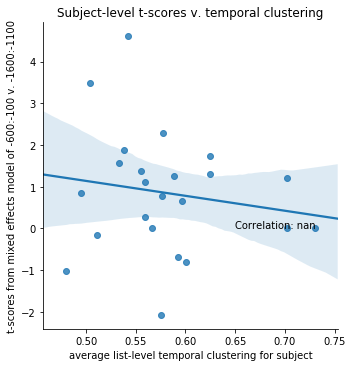

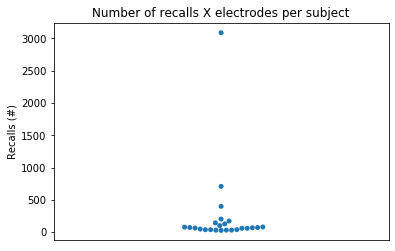

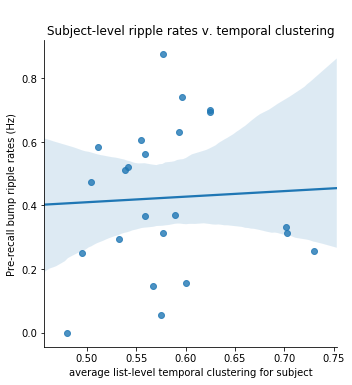

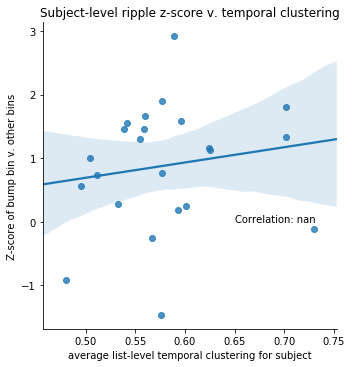

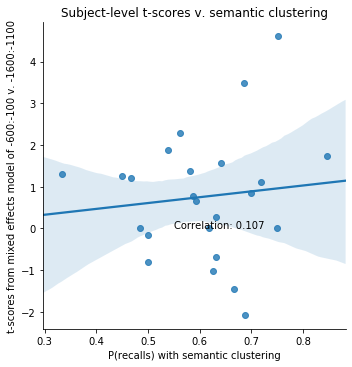

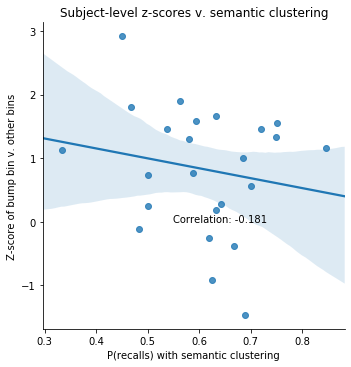

In [306]:
# subject-level plots for temporal clustering
import seaborn as sb

min_trials = 25

np.mean(sub_Ts1)
np.std(sub_Ts1)/np.sqrt(50)
np.mean(sub_Ts2)
np.std(sub_Ts2)/np.sqrt(50)

if min_trials > 0 and corrected_for_nans == 0:
    good_subs = np.array(trial_accum)>=min_trials
    sub_temporal_score = np.array(sub_temporal_score)[good_subs]
    rate_accum = np.array(rate_accum)[good_subs]
    sub_z_score = np.array(sub_z_score)[good_subs]
    sub_Ts1 = np.array(sub_Ts1)[good_subs]
    trial_accum = np.array(trial_accum)[good_subs]    
    sub_names = np.array(sub_names)[good_subs]
    sub_adjacent_lag_pct = np.array(sub_adjacent_lag_pct)[good_subs]
    corrected_for_nans = 1
    if exp == 'catFR1':
        sub_semantic_pct = np.array(sub_semantic_pct)[good_subs]

# Test 1 v. temporal clustering
plot_df = pd.DataFrame({'temporal_score':sub_temporal_score,'t-scores':sub_Ts1})
sb.lmplot(x='temporal_score',y='t-scores',data=plot_df)
subs_with_no_nans = ~np.isnan(np.array(sub_Ts1))
plot_corr = np.corrcoef(np.array(sub_temporal_score)[subs_with_no_nans],np.array(sub_Ts1)[subs_with_no_nans])[0][1]
annotate('Correlation: '+str(np.round(plot_corr,3)),(0.65,0))
ylabel('t-scores from mixed effects model of -600:-100 v. -1600:-1100')
xlabel('average list-level temporal clustering for subject')
title('Subject-level t-scores v. temporal clustering')
show()
# scatter(x=sub_temporal_score,y=sub_Ts1)
# scatter(sub_temporal_score,sub_Ts2); show()

# trial histogram
ax1 = sb.swarmplot(data=trial_accum) # data=sub_Ts1
ax1.set(xticks=[])
ylabel('Recalls (#)')
title('Number of recalls X electrodes per subject')
show()

# Pre-recall ripple rates v. temporal clutsering
plot_df = pd.DataFrame({'temporal_score':sub_temporal_score,'ripple_rates':rate_accum})
sb.lmplot(x='temporal_score',y='ripple_rates',data=plot_df)
plot_corr = np.corrcoef(sub_temporal_score,rate_accum)[0][1]
annotate('Correlation: '+str(np.round(plot_corr,3)),(0.65,1))
ylabel('Pre-recall bump ripple rates (Hz)')
xlabel('average list-level temporal clustering for subject')
title('Subject-level ripple rates v. temporal clustering')
show()

# Z-scores v. temporal clustering
plot_df = pd.DataFrame({'temporal_score':sub_temporal_score,'sub_z_score':sub_z_score})
sb.lmplot(x='temporal_score',y='sub_z_score',data=plot_df)
plot_corr = np.corrcoef(sub_temporal_score,sub_z_score)[0][1]
annotate('Correlation: '+str(np.round(plot_corr,3)),(0.65,0))
ylabel('Z-score of bump bin v. other bins')
xlabel('average list-level temporal clustering for subject')
title('Subject-level ripple z-score v. temporal clustering');
show()

# if catFR1 can create plots for semantic v. non-semantic clustering as well
if exp == 'catFR1':
    # Test 1 v. semantic clustering
    plot_df = pd.DataFrame({'semantic_score':sub_semantic_pct,'t-scores':sub_Ts1})
    sb.lmplot(x='semantic_score',y='t-scores',data=plot_df)
    subs_with_no_nans = ~np.isnan(np.array(sub_Ts1))
    plot_corr = np.corrcoef(np.array(sub_semantic_pct)[subs_with_no_nans],np.array(sub_Ts1)[subs_with_no_nans])[0][1]
    annotate('Correlation: '+str(np.round(plot_corr,3)),(0.55,0))
    ylabel('t-scores from mixed effects model of -600:-100 v. -1600:-1100')
    xlabel('P(recalls) with semantic clustering')
    title('Subject-level t-scores v. semantic clustering')
    show()
    
    # Z-scores v. semantic clustering
    plot_df = pd.DataFrame({'semantic_score':sub_semantic_pct,'t-sub_z_score':sub_z_score})
    sb.lmplot(x='semantic_score',y='t-sub_z_score',data=plot_df)
    subs_with_no_nans = ~np.isnan(np.array(sub_z_score))
    plot_corr = np.corrcoef(np.array(sub_semantic_pct)[subs_with_no_nans],np.array(sub_z_score)[subs_with_no_nans])[0][1]
    annotate('Correlation: '+str(np.round(plot_corr,3)),(0.55,0))
    ylabel('Z-score of bump bin v. other bins')
    xlabel('P(recalls) with semantic clustering')
    title('Subject-level z-scores v. semantic clustering')
    show()
elif exp == 'FR1':
    # t-score histogram for FR1
    ax1 = sb.swarmplot(data=sub_Ts1) # data=sub_Ts1
    ax1.set(xticks=[])
    ylabel('t-scores from mixed effects model of -600:-100 v. -1600:-1100')
    title('Pre-recall test by subject')
    show()
    
    # Test 1 v. temporal clustering LAG
    plot_df = pd.DataFrame({'lag_score':sub_adjacent_lag_pct,'t-scores':sub_Ts1})
    sb.lmplot(x='lag_score',y='t-scores',data=plot_df)
    subs_with_no_nans = ~np.isnan(np.array(sub_Ts1))
    plot_corr = np.corrcoef(np.array(sub_adjacent_lag_pct)[subs_with_no_nans],np.array(sub_Ts1)[subs_with_no_nans])[0][1]
    annotate('Correlation: '+str(np.round(plot_corr,3)),(0.5,0))
    ylabel('t-scores from mixed effects model of -600:-100 v. -1600:-1100')
    xlabel('P(recalls) with adjacent transitions')
    title('Subject-level t-scores v. temporal clustering')
    show()
    
    # Pre-recall ripple rates v. temporal clutsering
    plot_df = pd.DataFrame({'lag_score':sub_adjacent_lag_pct,'ripple_rates':rate_accum})
    sb.lmplot(x='lag_score',y='ripple_rates',data=plot_df)
    plot_corr = np.corrcoef(sub_adjacent_lag_pct,rate_accum)[0][1]
    subs_with_no_nans = ~np.isnan(np.array(rate_accum))
    plot_corr = np.corrcoef(np.array(sub_adjacent_lag_pct)[subs_with_no_nans],np.array(rate_accum)[subs_with_no_nans])[0][1]
    annotate('Correlation: '+str(np.round(plot_corr,3)),(0.5,1))
    ylabel('Pre-recall bump ripple rates (Hz)')
    xlabel('P(recalls) with adjacent transitions')
    title('Subject-level ripple rates v. temporal clustering')
    show()
    
    # Z-scores v. temporal clustering LAG
    plot_df = pd.DataFrame({'lag_score':sub_adjacent_lag_pct,'t-sub_z_score':sub_z_score})
    sb.lmplot(x='lag_score',y='t-sub_z_score',data=plot_df)
    subs_with_no_nans = ~np.isnan(np.array(sub_z_score))
    plot_corr = np.corrcoef(np.array(sub_adjacent_lag_pct)[subs_with_no_nans],np.array(sub_z_score)[subs_with_no_nans])[0][1]
    annotate('Correlation: '+str(np.round(plot_corr,3)),(0.5,0))
    ylabel('Z-score of bump bin v. other bins')
    xlabel('P(recalls) with adjacent transitions')
    title('Subject-level z-scores v. temporal clustering')

a=1;

In [472]:
# R1456D, semantic = 1, z-score = -0.84
# R1303E, semantic = 0.64, z-score = -2.1
# R1334T, semantic = 0.78, z-score = 0.55

sub_range = 0 #range(1,len(sub_names)) # 18
sub_names[sub_range]
sub_semantic_pct[sub_range]
trial_accum
sub_z_score[sub_range]

'R1065J'

0.625

array([3216,  126,   35,   34,   56,   69,   88,  100,   36,   92,   70,
        404,  216,  118,  774,  120,  192,   48,   47,  306,   42,   88,
        130,   84])

1.6418638485086015

## Big Raster!!

(3574, 2000)


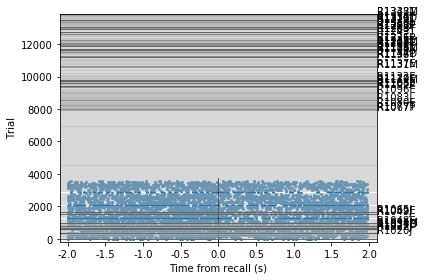

In [28]:
## for the raster and PSTH binarize the data by using the start indices of the ripple

save_raster = 0

%autoreload
psth_start = -2000
psth_end = 2000

# plot raster
subplots(1,1,figsize=(6,4))   #100 #6
scatter(np.where(start_array)[1]*sr_factor+psth_start,np.where(start_array)[0],s=4) # SWR time v. trial
xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,0.5))
xlabel('Time from recall (s)')
ylabel('Trial')
ax = plt.gca()
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))
last_sub = sub_names[0]
for s in range(1,len(trial_nums)):
    if sub_names[s] != last_sub:
        # plot dark gray line between subjects
        plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
        last_sub = sub_names[s]
        text(2100,0.5+np.sum(trial_nums[:s]),sub_names[s])
    else: # plot light gray line between sessions
        plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.7,.7,.7))
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
ax.autoscale(enable=True, axis='y', tight=True)
plt.tight_layout()
# print('Total FR events: '+str(total_recalls)) # these were in whole retrieval period so not kept in usual ripple alignment
# print('Kept FR events: '+str(kept_recalls))
print(start_array.shape);
if save_raster == 1:
    plt.savefig('../figures/'+sub+'_'+str(session)+'_FR1_raster.pdf',transparent=True)
a=1;

## PSTH with mixed effect CIs

In [280]:
%autoreload
# make a PSTH based on start times of SWRs
bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
psth_start = -2000
psth_end = 2000

PSTH,bin_centers = fullPSTH(start_array,bin_size,smoothing_triangle,sr,psth_start)
# bootstraps error bars by sampling from trials in raster with replacement samples number of
# times and then taking the standard deviation across those samples
# boot_samples = bootstrap(start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,psth_start))
# boot_SD = np.std(boot_samples,0)

# get binned start array (trials X bins)
binned_start_array = binBinaryArray(start_array,bin_size,sr_factor)
if pad > 0:
    binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
print('done making binned start_array with shape:')
binned_start_array.shape

## I set up recall selection above to work without this now...keeping it here until SWRanalysis is updated 2020-08-09
# get trial X 1 categorical names for subjects and sessions
# if select_semantic_temporal == 0:
#     subject_name_array,session_name_array = getSubSessPredictors(sub_names,sub_sess_names,trial_nums)

# note that output is the net ± distance from mean
CI_plot = getMixedEffectCIs(binned_start_array,subject_name_array,session_name_array)
print('CIs created!')

done making binned start_array with shape:


(1295, 36)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


CIs created!


# Stats on key recall-aligned bins

In [281]:
# let's measure significance at two key 500 ms bins (and compare to similar bin 500 ms earlier/later)
stats_bin = 500 # time bin width in ms to test stats on

first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

start_array.shape
binned_first_stats_array = start_array[:,int((first_start-psth_start)/sr_factor):int((first_end-psth_start)/sr_factor)]
binned_second_stats_array = start_array[:,int((second_start-psth_start)/sr_factor):int((second_end-psth_start)/sr_factor)]
binned_first_stats_array = binBinaryArray(binned_first_stats_array,stats_bin,sr_factor)
binned_second_stats_array = binBinaryArray(binned_second_stats_array,stats_bin,sr_factor)
print('done binning start_arrays'); binned_first_stats_array.shape

# first is test 1, second is test 2
bin_model1 = MEstatsAcrossBins(binned_first_stats_array[:,[0,2]],subject_name_array,session_name_array)
bin_model2 = MEstatsAcrossBins(binned_second_stats_array[:,[0,2]],subject_name_array,session_name_array)
# bin_model1.summary()
# bin_model2.summary()

(1295, 2000)

done binning start_arrays


(1295, 3)

Test 1 p-value: 0.0002219341966666468
Test 2 p-value: 0.5068597397320673
1295 recalls


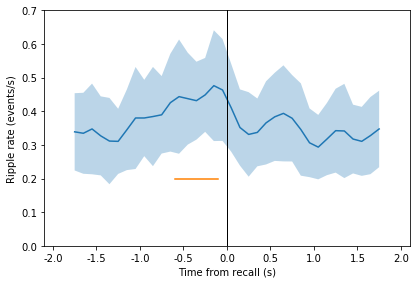

In [282]:
# plot PSTH and save data for plot (see SWRplots)

save_plot_data = 1

subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(psth_start,psth_end,binsize)

# plot smoothed mean +/- CI
if pad > 0:
    plot(xr[pad:-pad],PSTH[pad:-pad])
    fill_between(xr[pad:-pad], PSTH[pad:-pad]-CI_plot[0,:], PSTH[pad:-pad]+CI_plot[0,:], alpha = 0.3)
else:
    plot(xr,PSTH)
    fill_between(xr, PSTH-CI_plot[0,:], PSTH+CI_plot[0,:], alpha = 0.3)

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
tight_layout()
ax = plt.gca()
ylim = 0.7 # keep it here since occasionally CIs get kinda high
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]

# plot bands of significance
if bin_model1.pvalues[1] < 0.05:
    plot([first_end-stats_bin,first_end],[0.2,0.2],color=(1,0.5,0))
if bin_model2.pvalues[1] < 0.05:
    plot([second_start,second_start+stats_bin],[0.2,0.2],color=(1,0.5,0))
num_trials = start_array.shape[0]
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
print(str(num_trials)+' recalls')

if save_plot_data == 1:
    # get strings for path name for save and loading cluster data
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
        
    path_name = '/home1/john/SWR/figures/'+subfolder
    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    if upper_or_lower == 1:
        upper_label = 'upper'
    elif upper_or_lower == 2:
        upper_label = 'lower'
    else: 
        upper_label = ''
        
    fn = os.path.join(path_name,
        'SWRCLUSTER_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+
                      '_'+soz_label+'_recalls-'+str(min_recalls)+'_'+upper_label+'_'
                      +str(select_semantic_temporal)+'.p')            
    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH':PSTH,'CI_plot':CI_plot,'num_trials':num_trials,
                    'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_first_stats_array':binned_first_stats_array,'binned_second_stats_array':binned_second_stats_array,
                    'subject_name_array':subject_name_array,'session_name_array':session_name_array,
                    'temporal_clustering_key':temporal_clustering_key,
                    'semantic_clustering_key':semantic_clustering_key,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array}, f)
a=1;

In [504]:
path_name

'/home1/john/SWR/figures/NOTFIRSTRECALLS'

In [288]:
bin_model1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: ripple_rates
No. Observations: 3646    Method:             ML          
No. Groups:       44      Scale:              0.8201      
Min. group size:  2       Likelihood:         -4824.8719  
Max. group size:  1824    Converged:          Yes         
Mean group size:  82.9                                    
-----------------------------------------------------------
             Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    0.311     0.029  10.808  0.000   0.255   0.368
bin[T.1]     0.111     0.030   3.694  0.000   0.052   0.170
session Var  0.010     0.007                               
==========================================================

"""

## Plots by hippocampal subfield! ##NOTE: I usually do this above one by one now##

In [711]:
# Let's plot the change in SWRs by subfield
pre_time = -2000 # how long to look for ripples before/after recall
post_time = 2000
# CA1/CA3/DG/sub are 4 regions
ca1 = []; ca3 = []; subic = []; dg = []
ca1_tn = []; ca3_tn = []; subic_tn = []; dg_tn = []
previous_row = 0
for s in range(len(HPC_names)):
    # first, get the change in SWRs from before until after recall
    new_trials = trial_nums[s]
    if HPC_names[s].find('ca1')>=0:
        ca1 = superVstack(ca1,start_array[previous_row:int(previous_row+new_trials)])
        ca1_tn = np.append(ca1_tn,new_trials) # record trial numbers for raster plot
    elif HPC_names[s].find('ca3')>=0:
        ca3 = superVstack(ca3,start_array[previous_row:int(previous_row+new_trials)])
        ca3_tn = np.append(ca3_tn,new_trials)
    elif HPC_names[s].find('sub')>=0:
        subic = superVstack(subic,start_array[previous_row:int(previous_row+new_trials)])
        subic_tn = np.append(subic_tn,new_trials)
    elif HPC_names[s].find('dg')>=0:
        dg = superVstack(dg,start_array[previous_row:int(previous_row+new_trials)])
        dg_tn = np.append(dg_tn,new_trials)
    previous_row = int(previous_row+new_trials)
separate_HPC_arrays = np.array([ca1,ca3,subic,dg])
separate_HPC_tns = np.array([ca1_tn,ca3_tn,subic_tn,dg_tn])

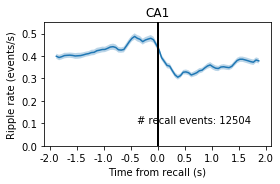

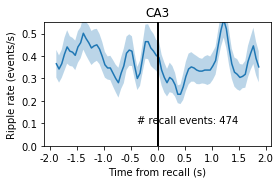

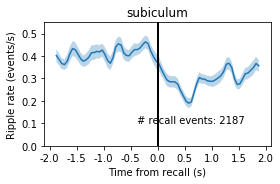

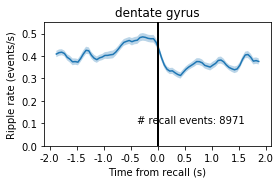

[12504.0, 474.0, 2187.0, 8971.0]


In [723]:
# plot the separate PSTHs
# make a PSTH based on start times of SWRs
binsize = 50 #100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
xripplerange = range(int((pre_time+IRI)/sr_factor),int((pre_time+IRI+(post_time-pre_time))/sr_factor)) 
plot_names = ['CA1','CA3','subiculum','dentate gyrus']

for pl in range(4):
    temp_start_array = separate_HPC_arrays[pl][:,xripplerange]

    PSTH,bin_centers = fullPSTH(temp_start_array,binsize,smoothing_triangle,sr,pre_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
    boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
                   bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_time))
    boot_SD = np.std(boot_samples,0)
    
#     # I want to get a more accurate peak bin too....should really fit a polynomial to get a smoothed peak 
#     precise_PSTH,precise_bin_centers = fullPSTH(temp_start_array,25,5,sr,pre_time)
#     plot(precise_PSTH);show()

    # plot PSTH
    subplots(1,1,figsize=(4,8/3))
    xr = bin_centers #np.arange(pre_time,post_time,binsize)
    plot(xr[pad:-pad],PSTH[pad:-pad])
    fill_between(xr[pad:-pad], (PSTH+boot_SD)[pad:-pad], (PSTH-boot_SD)[pad:-pad], alpha = 0.3)

    xticks(np.arange(pre_time,post_time+1,500),np.arange(pre_time/1000,post_time/1000+1,500/1000))
    xlabel('Time from recall (s)')
    ylabel('Ripple rate (events/s)')
    ax = plt.gca()
    ax.set_ylim(0,0.55)
    ax.set_xlim(pre_time-100,post_time+100)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=2,linestyle='-',color=(0,0,0))
    title(plot_names[pl])
    text(-380,0.1,'# recall events: '+str(separate_HPC_arrays[pl].shape[0]))
    tight_layout(); show()

# # separated rasters
# for pl in range(4):
#     temp_start_array = separate_HPC_arrays[pl][:,xripplerange]
#     temp_trial_num_array = separate_HPC_tns[pl]

#     # plot rasters for each
#     subplots(1,1,figsize=(6,sum(temp_trial_num_array)/550))   
#     scatter(np.where(temp_start_array)[1]*sr_factor+pre_time,np.where(temp_start_array)[0],s=4) # SWR time v. trial
#     xticks(np.arange(pre_time,post_time+1,500),np.arange(pre_time/1000,post_time/1000+1,0.5))
#     xlabel('Time from recall (s)')
#     ylabel('Trial')
#     ax = plt.gca()
#     ax.set_xlim(pre_time-100,post_time+100)
#     plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))
#     tn_ct = 0
#     for tn in temp_trial_num_array:
#         tn_ct = tn_ct + tn
#         plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+tn_ct)*np.ones(2),linewidth=0.5,linestyle='-',color=(.7,.7,.7))
#     plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
#     plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+tn_ct)*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
#     title(plot_names[pl])
print([sum(xx) for xx in separate_HPC_tns]);

In [91]:
# temporal clustering testbed

def test_removeRepeatsBySerialpos(serialpositions):
    #Takes array of numbers (serial positions) and removes any repeated ones
    items_to_keep = np.ones(len(serialpositions)).astype(bool)
    items_seen = []
    idx_removed = []
    for idx in range(len(serialpositions)):
        if serialpositions[idx] in items_seen:
            items_to_keep[idx] = False
            idx_removed.append(idx)
        items_seen.append(serialpositions[idx])

    final_vec = np.array(serialpositions)[items_to_keep]
    return final_vec, idx_removed

# recalls_serial_pos = [11, 11, 8, 8,7,-999, -999, 1, 11,2, -999, 7, 8, 8, 3, -999] # works!
# recalls_serial_pos = [-1000,     0,     6,     9, -1000,     6]
# recalls_serial_pos = [6, 1, 0, 2, 9, 9, 9, 7, 6, 6, 6, 9, 8, 10, 10, 10]
# recalls_serial_pos = [6, 1, 1, 6, 1, 1, 1, 6, 9, 1, 9, 2, 2, 5, 5]
recalls_serial_pos = [8, 8, 8, 8, 8, 8, 1, 4, 8, 8, 8, 11, 11, 11, 3]

_,idx_to_remove = test_removeRepeatsBySerialpos(recalls_serial_pos)
        
# don't remove (duplicate value) intrusions
keep_intrusions = np.where(np.array(recalls_serial_pos)<=-999)[0]
idx_to_remove = np.setdiff1d(idx_to_remove, keep_intrusions)

print(recalls_serial_pos)

actually_remove = []
for i in range(len(recalls_serial_pos)):
    if i in idx_to_remove:
        if recalls_serial_pos[i] == recalls_serial_pos[i-1] and \
            recalls_serial_pos[i] > -990 and \
            (recalls_serial_pos[i] not in recalls_serial_pos[:i-1]):
            
            actually_remove.append(i)
        else:
            # if a string of longer than two but haven't been used before remove all but one
            if (recalls_serial_pos[i] == recalls_serial_pos[i-1]) and (i<len(recalls_serial_pos)-1):
                j = i
                while j < len(recalls_serial_pos):
                    if recalls_serial_pos[j]==recalls_serial_pos[j+1]:
                        actually_remove.append(j) # remove consecutive repeats
                        j+=1
                    else:
                        actually_remove.append(j) # remove last consecutive repeat
                        break
            else:
                recalls_serial_pos[i] = -999 # if not a consecutive repeat label it like intrusion so don't create false transitions

if len(actually_remove)>0:
    recalls_serial_pos = np.delete(recalls_serial_pos,actually_remove)
print(recalls_serial_pos)

[8, 8, 8, 8, 8, 8, 1, 4, 8, 8, 8, 11, 11, 11, 3]
[   8    1    4 -999 -999 -999   11    3]


In [95]:
# keeping only the last repeat of consecutive repeats testbed

recalls_serial_pos = [8, 8, 8, 8, 8, 8, 1, 4, 8, 8, 8, 11, 11, 11, 3]

sps,idx_to_remove = test_removeRepeatsBySerialpos(recalls_serial_pos)
sps
idx_to_remove

remaining_sps = np.delete(recalls_serial_pos,np.array(recalls_serial_pos)[idx_to_remove])
remaining_sps

array([ 8,  1,  4, 11,  3])

[1, 2, 3, 4, 5, 8, 9, 10, 12, 13]

array([ 8,  8,  8,  8,  8,  8,  1,  4,  8,  8, 11, 11,  3])

## Average SWRs across first 10 s of retrieval (come here after loading from cluster data using 'whole_retrieval')

In [180]:
## DO YOU WANT TO SELECT A SUBFIELD OR CLUSTER METHOD?? ##  

# Note: if you want to change a parameter in here after running you need to reload above

select_subfield = True 

if select_subfield == True:
    location_selected = ['ca1','dg'] # 'ca3' # 'dg' 'ca1' 'sub' ['ca1','dg']<-can select 2 like this as well (code looks for both)
else:
    location_selected = ''
    
# min_recalls = 4

select_semantic_temporal = 0
# 0 means neither (use for no clustering or subject-level), 
# 1 means semantic (not using for FR1 anymore), 
# 2 means temporal
# commandeered this framework for 3: temporal by lag. There upper/lower actually means lag=1 and lag≥3

# if selecting for semantic/temporal clustering subset of trials pick your subset

upper_or_lower = 0 ### KEEP AS 0 FOR WHOLE_RETRIEVAL SINCE ALL SUBJECT-LEVEL ANALYSES ###

## For FR1: ##
# 1 means higher than upper_percentile (clustered) 
# 2 means lower than lower (unclustered)
# 0 means nothin...use for subject_level plots
# for trial_lag (3 above for select_semantic_temporal) upper_or_lower=1 means lag==1 and =2 means ≥4

## For catFR1: ##
# 1 means all semantically clustered (adjacent AND remote semantic transitions), i.e. A&B
# 2 means all other except adjacent non-semantic (remote non-semantic and dead ends), i.e. D&Z

desired_sample_rate = 500.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

start_array,end_array = getStartEndArrays(ripple_array) # get start array
print('Got start_array of length: '+str(len(start_array)))

## select by clustering scores!!! ## 
from scipy.stats import scoreatpercentile

# # select cluster method
# if select_semantic_temporal == 1: # semantic!
#     selection_name = 'SEMANTIC'
#     sorting_values = list_level_semantic
# elif select_semantic_temporal == 2: # temporal!
#     selection_name = 'TEMPORAL'   
#     sorting_values = list_level_temporal
# # elif select_semantic_temporal == 3: # temporal by lag!
# #     selection_name = 'TEMPORAL_LAG'
# #     sorting_values = np.array(serialpos_lags)
# else:
#     selection_name = 'ALL'    
#     sorting_values = np.ones(len(list_level_temporal))    
      
# select subset of recalls
if upper_or_lower == 1:
    above_or_below = 'above'
    percentile = upper_percentile
elif upper_or_lower == 2:
    above_or_below = 'below'
    percentile = lower_percentile
else:
    above_or_below = ''
    percentile = ''

subject_name_array,session_name_array,electrode_array,channel_coords_array = getSubSessPredictors(sub_names,sub_sess_names,
                                                                            trial_nums,electrode_labels,channel_coords)
print('Got session_name_array of length: '+str(len(session_name_array)))     
        

# get locations if selected

if select_subfield == True:
    # create the full vector of location names
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(sorting_values))
    
# # now that I'm putting 'nans' in for final recalls in each list remove all those trials
# nonnan_idxs = np.array(temporal_clustering_key)!='nan'
# location_mask = location_mask[nonnan_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = location_mask == 1 #+selected_recalls)==2
start_array = start_array[updated_recalls]
    
# need to translate these predictors to vector and select recalls
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
temporal_clustering_key = np.array(list_level_temporal)[updated_recalls]
semantic_clustering_key = np.array(list_level_semantic)[updated_recalls]

print('done selecting '+selection_name+' trials '+above_or_below+' '+str(percentile))
## ##

print('Got start_array with shape:')
print(start_array.shape)

Got start_array of length: 9485
Got session_name_array of length: 9485
done selecting ALL trials  
Got start_array with shape:
(7767, 7000)


In [181]:
# should all be same after loading and running previous cell
start_array.shape
len(temporal_clustering_key)
len(semantic_clustering_key)
len(subject_name_array)

(7767, 7000)

7767

7767

7767

In [182]:
# now can split by clustering values for each subject and compare

select_all_semantic = 1 # when selecting clustered v. unclustered semantic, include adjacent or do only remote?
min_trials_per_sub = 50

# how to split %ile values?
# upper_percentile = 0.75;  lower_percentile = 0.25
upper_percentile = 0.5;  lower_percentile = 0.5

measure_length = 10000 # 11000, aligned from offset to how far?
offset = 1000 # consider from -1:measure_length s to make sure I don't miss pre-recall bump
            # justified doing anyway since aligned to beep_end now but for many beep_start seems to be cue 
IRI = 2000 # essentially acts as buffer since I stuck this on either end of 10 s array

# first let's remove the buffers from start_array so can get a single SWR mean
# for each condition in the next loop
start_array_Xsec = start_array[:,int((IRI-offset)/sr_factor):int((IRI-offset+measure_length)/sr_factor)]

lower_temporal = []; upper_temporal = []
lower_semantic = []; upper_semantic = []
for sub in np.unique(subject_name_array):
    idxs_for_sub = [sub in s for s in subject_name_array]
    
    if sum(idxs_for_sub) >= min_trials_per_sub:

        start_array_for_sub = start_array_Xsec[idxs_for_sub]

        # temporal clustering
        
        temporal_for_sub = np.array(temporal_clustering_key)[idxs_for_sub]
        nonnan_values = ~isNaN(temporal_for_sub)
        temp_values_for_sub = temporal_for_sub[nonnan_values]

        upper_thresh = scoreatpercentile(temp_values_for_sub,100*upper_percentile)
        upper_temporal.append(500*np.mean(start_array_for_sub[np.arange(len(nonnan_values))][temporal_for_sub > upper_thresh]))
        
        lower_thresh = scoreatpercentile(temp_values_for_sub,100*lower_percentile)
        if lower_percentile == 0.5:
            lower_temporal.append(500*np.mean(start_array_for_sub[np.arange(len(nonnan_values))][temporal_for_sub <= lower_thresh]))
        else:
            lower_temporal.append(500*np.mean(start_array_for_sub[np.arange(len(nonnan_values))][temporal_for_sub < lower_thresh]))

        # semantic clustering
        
        semantic_for_sub = np.array(semantic_clustering_key)[idxs_for_sub]
        
        if exp == 'catFR1':             # A&C are clustered. B&D are not. A&B are adjacent, C&D are remote
            
            # get mask of lower v. upper semantic
            
            if select_all_semantic == 1:
                semantic_mask = np.zeros(sum(idxs_for_sub))
                for trial in range(sum(idxs_for_sub)):
                    if (sum([test=='A' for test in semantic_for_sub[trial]]) + sum([test=='C' for test in semantic_for_sub[trial]])) \
                     > (sum([test=='B' for test in semantic_for_sub[trial]]) + sum([test=='D' for test in semantic_for_sub[trial]])):
                        semantic_mask[trial] = 1
                    elif (sum([test=='A' for test in semantic_for_sub[trial]]) + sum([test=='C' for test in semantic_for_sub[trial]])) \
                     < (sum([test=='B' for test in semantic_for_sub[trial]]) + sum([test=='D' for test in semantic_for_sub[trial]])):
                        semantic_mask[trial] = 2
            else: # use remote comparison only
                semantic_mask = np.zeros(sum(idxs_for_sub))
                for trial in range(sum(idxs_for_sub)):
                    if sum([test=='C' for test in semantic_for_sub[trial]]) > sum([test=='D' for test in semantic_for_sub[trial]]):
                        semantic_mask[trial] = 1
                    elif sum([test=='D' for test in semantic_for_sub[trial]]) > sum([test=='C' for test in semantic_for_sub[trial]]):
                        semantic_mask[trial] = 2                
            upper_semantic.append(500*np.mean(start_array_for_sub[semantic_mask==1]))
            lower_semantic.append(500*np.mean(start_array_for_sub[semantic_mask==2]))
                        
        elif exp == 'FR1':
            nonnan_values = ~isNaN(semantic_for_sub)
            temp_values_for_sub = semantic_for_sub[nonnan_values] # doesn't this index wrong??
            print(sub)
            
            upper_thresh = scoreatpercentile(temp_values_for_sub,100*upper_percentile)
            upper_semantic.append(500*np.mean(start_array_for_sub[np.arange(len(nonnan_values))][semantic_for_sub > upper_thresh]))
            
            lower_thresh = scoreatpercentile(semantic_for_sub,100*lower_percentile)
            if lower_percentile ==  0.5:
                lower_semantic.append(500*np.mean(start_array_for_sub[np.arange(len(nonnan_values))][semantic_for_sub <= lower_thresh]))
            else:
                lower_semantic.append(500*np.mean(start_array_for_sub[np.arange(len(nonnan_values))][semantic_for_sub < lower_thresh]))


/home1/john/johnModules/general.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  second_test = num == 'nan' # some string types don't work with above line
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in less_equal
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home1/john/anaconda3/envs/env1/lib/python3.7/si

R1002P
R1022J
R1034D
R1048E
R1056M
R1065J
R1077T
R1080E
R1083J
R1096E
R1112M
R1120E
R1122E
R1137E
R1138T
R1147P
R1154D
R1168T
R1195E
R1200T
R1203T
R1215M
R1217T
R1236J
R1243T
R1283T
R1293P
R1297T
R1306E
R1310J
R1311T
R1313J
R1325C
R1334T
R1338T


In [183]:
start_array.shape
start_array_Xsec.shape
exp

(7767, 7000)

(7767, 5000)

'FR1'

upper and lower temporal:
0.33304297947627376
0.33983543015169915


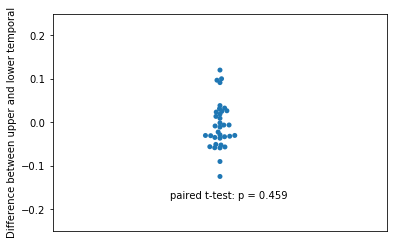

upper and lower semantic:
0.3293659902680229
0.33791826270233927


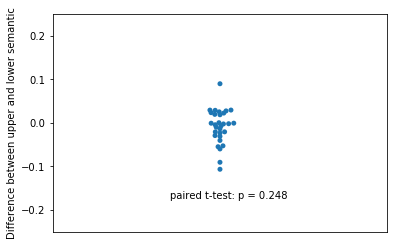

In [184]:
import seaborn as sb

# select nonNaNs
good_temporal = ~isnan(upper_temporal) & ~isnan(lower_temporal)
upper_temporal = np.array(upper_temporal)[good_temporal]
lower_temporal = np.array(lower_temporal)[good_temporal]
good_semantic = ~isnan(upper_semantic) & ~isnan(lower_semantic)
upper_semantic = np.array(upper_semantic)[good_semantic]
lower_semantic = np.array(lower_semantic)[good_semantic]

print('upper and lower temporal:')
print(np.mean(upper_temporal))
print(np.mean(lower_temporal))
temporal_diff = np.array(upper_temporal)-np.array(lower_temporal)
ax1 = sb.swarmplot(data = temporal_diff)
ax1.set(xticks = [])
ax1.set(ylim = (-0.25,0.25))
ylabel('Difference between upper and lower temporal')
text(-0.15,-0.175,'paired t-test: p = '+str(np.round(stats.ttest_rel(upper_temporal,lower_temporal)[1],3)))
show()

print('upper and lower semantic:')
print(np.mean(upper_semantic))
print(np.mean(lower_semantic));
semantic_diff = np.array(upper_semantic)-np.array(lower_semantic)
ax2 = sb.swarmplot(data = semantic_diff)
ax2.set(xticks=[])
ax2.set(ylim = (-0.25,0.25))
ylabel('Difference between upper and lower semantic')
text(-0.15,-0.175,'paired t-test: p = '+str(np.round(stats.ttest_rel(upper_semantic,lower_semantic)[1],3)))
show();

In [144]:
ripple_array.shape
len(temporal_clustering_key)
len(semantic_clustering_key)
len(subject_name_array)
len(list_level_temporal)
len(sorting_values)
list_level_temporal[0:5]
len(HPC_names)
len(serialpos_lags)

done selecting TEMPORAL trials  
Got start_array with shape:
(6453, 7000)


9293

(array([1251., 1518., 1899., 1991., 1315.,  805.,  278.,  150.,   63.,
          23.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

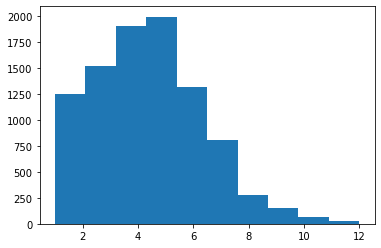

In [142]:
len(list_trial_nums)
plt.hist(list_trial_nums)